# Модель предсказания температуры стали

В процессе производства в сталь добавляют различные примеси и легирующие добавки , при этом сталь несколько раз нагревают.  
Модель должна предсказывать температуру стали в ходе процесса.   

Заказчик предоставил данные по обработке примерно 3000 партий стали.   
На основании этих данных построена модель, при тестировании предсказавшая температуру со средней точностью до 6 градусов 

In [1]:
!pip install sqlalchemy
!pip install lightgbm

In [2]:
import pandas as pd
import numpy as np
import functools as fnc
import operator as opr
import warnings

from sqlalchemy import create_engine 

from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.base import BaseEstimator,TransformerMixin
 
from sklearn.preprocessing import StandardScaler 
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression,SGDRegressor
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

import lightgbm as lgb
from sklearn.neural_network import MLPRegressor

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
RANDOM_STATE = 131223

rmse = lambda x,y: mean_squared_error(x,y,squared=False)
rmse.__name__ = 'RMSE'
# cosine = lambda a,b : cosine_distances([a],[b]).flatten()
# cosine.__name__ = 'cosine_score'

all_regression_metrics = [mean_absolute_error,rmse,r2_score]
def print_metrics( y,pr, metrics = all_regression_metrics ):
    scores = {}
    for metric in metrics:
        scores[metric.__name__]= metric(y,pr)
        print(f"{metric.__name__}: {scores[metric.__name__]} " )
    return scores

#### Библиотека классов 

Я использую нексолько классов, отлаженных в предыдущих проектах, для понятного вывода результатов кроссвалидации.
Класс ParsedResult собирает во фрейм результаты из cv_results_ и
класс ResultPlotter строит графики из этого фрейма
Класс Styler - вспомогательный для автоматического выбора типа линий

In [4]:
class ParsedResult:
    def __init__(self,result,metric_name='score',sample_name='mean'):
        self.df = pd.DataFrame.from_dict( 
            { k:v for k,v in result.items() if k not in ['params']}
        )
# drop param_ prefix from column names for tidy display         
        self.primary_score=f"{sample_name}_test_{metric_name}"
        param_names = [ c for c in self.df.columns if c[:6]=='param_' ]        
        self.param_cols = [ c[6:] for c in param_names ]              
        self.df = self.df.rename( columns={ p:c for p,c in zip(param_names,self.param_cols) } )
# also drop model_ prefix which we use for model grid in pipeline   
        model_names = [ c for c in self.df.columns if c[:7]=='mod__' ]
        self.param_cols = [c[7:]  if c[:7]=='mod__' else c for c in self.param_cols ]
        self.model_cols = [ c[7:] for c in model_names ]   
        self.df = self.df.rename( columns={ p:c for p,c in zip(model_names,self.model_cols) } )
# select parameters, for which tested several values and arrange them descending (by number of differnt values)
        values_per_cols = list(zip( self.param_cols,[ len( np.unique( self.df[c].values ) ) for c in self.param_cols]))
        self.multi_value_cols =[it[0] for it in sorted(values_per_cols, key=lambda pair:pair[1],reverse=True) if it[1]>1 ]
# some object columns may be not string (f.e. lists)
        for i in range(len(self.df.columns)):
            if self.df.dtypes[i]=='object':
                self.df[self.df.columns[i]] = self.df[self.df.columns[i]].astype(str)
        
            
    def select(self, index,values=[],filters={},agg=[] ):
        values = [ [self.primary_score] ,values][bool(values)]
        if len(filters)>0 :
            condition = 'and'.join([ f" {k}=={v} " for k,v in filters.items() ]) 
            filtered = self.df.query(condition)    
        else:
            filtered = self.df
        cols = [ c for c in self.multi_value_cols if c not in list(filters.keys())+[index]+values ]      
        return(self.df.pivot_table(index=index,values=values,columns=cols)  )

In [5]:
class Styler:
    base_array=[]
    def __init__(self,param_array=[]):
        self.params = [ self.base_array,param_array][bool(param_array)]
    
    def key(self):
        pass
    
    def put(self,dct,index):
        dct[self.key()] = self.params[index]
        
class ColorStyler(Styler):
    base_array=[*'rgbykm']
    def key(self):
        return('color')

class DashStyler(Styler):
    base_array=['--',':','-.','-']
    def key(self):
        return('ls')
    
class WidthStyler(Styler):
    base_array=[ 2,4,7]
    def key(self):
        return('lw')

class AlphasStyler(Styler):
    base_array=[ .3,.9]
    def key(self):
        return('alpha')

In [6]:
multiply = lambda array: fnc.reduce( opr.mul,array,1 )
class ResultPlotter:
    base_params = {
        'colors':[*'rgbykm'],
        'styles':['--',':','-.','-',(0, (1, 10)),(0, (5, 10))],
        'widths':[ 2,4,7],
        'alphas':[.3,.8],
        'figsize': (20,8),
        'logscale':""
    }
    
    def __init__(self, test, params = {} ):
 #       self.model = test.model
        self.df= test#.sel
        self.params=self.base_params | params
        self.stylers = [ColorStyler(self.params['colors']),DashStyler(self.params['styles']),
                        WidthStyler(self.params['widths']),AlphasStyler(self.params['alphas'])]
        self.mcols = self.df.columns      
        self.lev_names = list(self.mcols.names)
        self.num_levels= len(self.lev_names)
        self.level_sizes=[ len(set(self.mcols.get_level_values(x))) for x in self.lev_names]
        
        # if level 0("values of pivot") is one-valued, then start apply styles from columns 1  
        self.start_level = int(  self.level_sizes[0] == 1   )
# TODO: refactoring needed here, one or two new functions to encapsulate this feature
#       also to print short description for " result thread" 

        

# auxliary func to forms sequence of indexes for levels
# result is need index on the level  which may be one of color|dashstyle|linewidth
    def idx_on_level(self,idx, lev_num):
        items_on_hyperplane = multiply(self.level_sizes[(lev_num+1):]) 
        return idx//items_on_hyperplane% self.level_sizes[lev_num]
    
    def plot(self):
        fig,ax = plt.subplots(figsize=(20,12))
        if 'x' in self.params['logscale'].lower():
            ax.set_xscale('log')
        if not self.lev_names[0]:
            self.lev_names[0]='res.thread'
            
        for i_mcol in range(len( self.mcols)):
            graph_params = {}
            for i_level in range(self.start_level,self.num_levels):
                self.stylers[i_level-self.start_level].put( graph_params, self.idx_on_level(i_mcol,i_level) ) 
            idx=self.mcols[i_mcol]
            
            levels_for_label=[ f"{n}:{j} " for n,j in zip(self.lev_names[self.start_level:],idx[self.start_level:]) ] 
            graph_params['label'] = ','.join( levels_for_label )
            ax.plot(self.df[idx] ,**graph_params)
            ax.set_title(f"Тест {self.params['title']}")
            ax.set_xlabel('learning rate')
            ax.set_ylabel(f"{self.params['metric']}")
            ax.legend()

## Загрузка

In [7]:
db_config = {
'user': 'praktikum_student',# имя пользователя
'pwd': 'Sdf4$2;d-d30pp',# пароль
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432,# порт подключения
'db': 'data-science-final'# название базы данных,
}
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)
engine = create_engine(connection_string) 

#### Предварительный анализ данных о температуре

Таблица с даными о температуре наиболее важна, она содержит целевой признак и там больше всего вопросов с корректностью данных

Во-первых, к сожалению, в таблице нет даты замеров , только время, поэтому довольно сложно обработать те партии , где в измерениях  есть переход через границу суток.

In [8]:
q_temp_intervals = f'''
select 
  key,
  min(t."MesaureTime") min_time,
  max(t."MesaureTime") max_time,
   extract('epoch' from max(t."MesaureTime") - min(t."MesaureTime")) interval_sec
 from steel.data_temp t
group by key
'''
df_temp_intervals = pd.read_sql_query(q_temp_intervals, con=engine)
df_temp_intervals[abs(df_temp_intervals.interval_sec)>12*3600].sort_values(by='interval_sec',ascending=False)

,key,min_time,max_time,interval_sec
2813,2744,00:01:02,23:57:55,86213.0
50,2855,00:00:48,23:57:35,86207.0
1682,2063,00:01:46,23:58:18,86192.0
201,2526,00:01:42,23:57:34,86152.0
1681,2827,00:00:27,23:56:10,86143.0
...,...,...,...,...
1625,1263,00:21:02,23:41:29,84027.0
2764,46,00:42:24,23:55:12,83568.0
225,44,00:35:31,22:50:26,80095.0
3046,1958,01:51:42,22:43:59,75137.0


Найдена 71 партия, где разброс времени почти на сутки. Визуально понятно, что это серии продолжительностью до 3 часов, которые начались в разные дни, но автоматически находить в них первое и последнее значение довольно сложно.
Я все же решил их выбросить -
во-первых их немного, по сравнению с общим количеством, и с теми данными, которые все равно придется удалять
во-вторых в реальной производственной задаче я бы попросил полное время с датой, наверняка это несложно реализовать.

Следующий момент -есть много партий только с одним валидным замером - там либо пустые значения, либо температура меньше 1500. Как я понимаю фраза  <i>"значения температуры ниже 1500 градусов — аномальные"</i> означает, что использовать их нельзя 

In [9]:
q_temp_count = f'''
select count(*) from (
    select key
     from steel.data_temp t
     where t."Temperature" >= 1500 
    group by key
    having count(*)=1
)  c1   
'''
pd.read_sql_query(q_temp_count, con=engine)

,count
0,740


Всего таких серий 740 , так как по серии с одним замером нельзя ни обучить модель, ни проверить предсказания, эти данные бесполезны и их придется удалить.

Следующее условие на температуры для серий позволяет исключить такие данные ( с одним значением температуры или с переходом через сутки) уже на этапе загрузки.
Все загружаемые таблицы будут объединяться  с таким запросом по полю <i>key</i>

In [10]:
correct_temp_clause = f'''
   select key,
      m_temp,
      y_temp,
      qty_temp,
      min(temp_time) begin_time,
      extract('epoch' from max(temp_time ) - min(temp_time)) t_temp   
      from ( 
        select 
           tmr.key, 
           tmr."MesaureTime" temp_time, 
           first_value(tmr."Temperature") over (partition by key order by tmr."MesaureTime"
              rows between unbounded preceding and unbounded following ) m_temp,
           last_value(tmr."Temperature") over (partition by key order by tmr."MesaureTime" 
              rows between unbounded preceding and unbounded following ) y_temp,
           count(tmr."Temperature") over (partition by key order by tmr."MesaureTime" 
              rows between unbounded preceding and unbounded following ) qty_temp 
         from steel.data_temp tmr  
         where tmr."Temperature" >= 1500 and tmr."Temperature" is not null 
      )  temp_window
      group by key,m_temp,y_temp,qty_temp
      having count(*) >1 
       and max(temp_time)- min(temp_time) < interval '12 hours'
'''              

mean = 1589.1,std=25.02


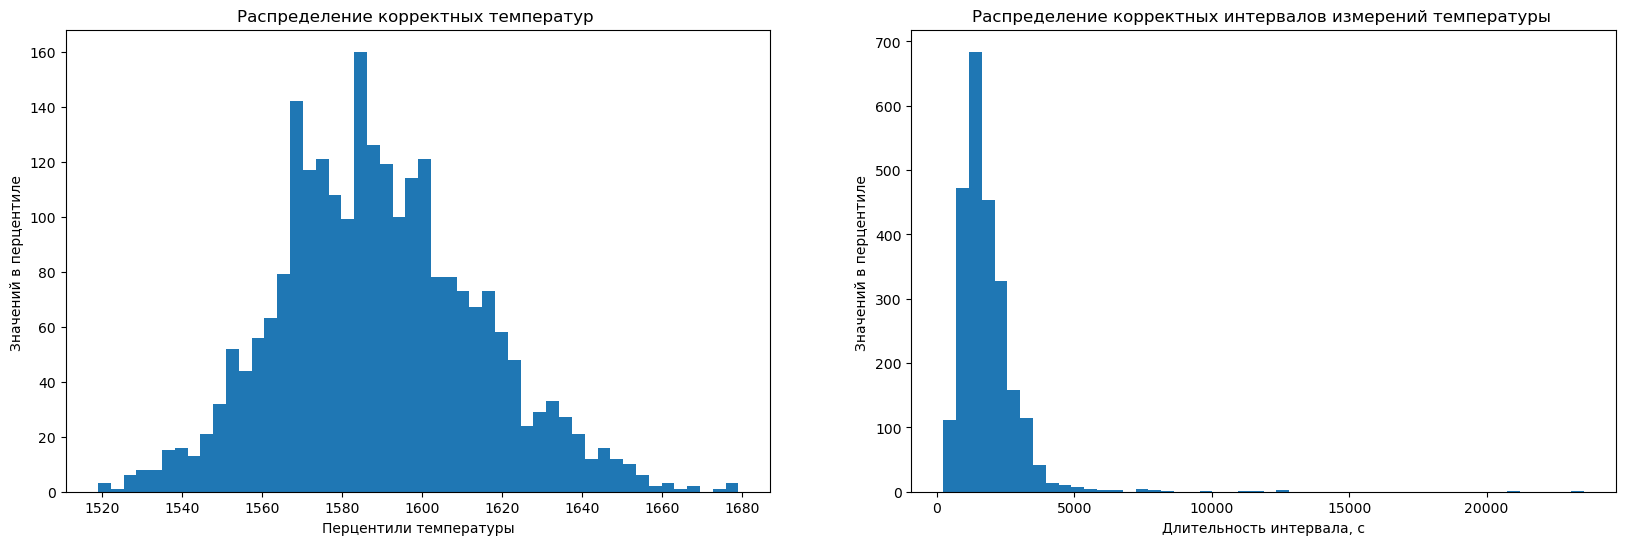

In [11]:
q_temp = f'''
select dt."MesaureTime" time,dt."Temperature" temp ,ct.t_temp 
  from steel.data_temp dt
  join ( {correct_temp_clause} ) ct
  using(key)
  where dt."MesaureTime" = begin_time
'''
df_temp = pd.read_sql_query(q_temp, con=engine)
df_temp= df_temp[df_temp.temp>1500]
fig,axs = plt.subplots(1,2,figsize=(20,6))
axs[0].hist(df_temp.temp,bins=50)
axs[0].set_title('Распределение корректных температур ')
axs[0].set_xlabel('Перцентили температуры')
axs[0].set_ylabel('Значений в перцентиле ')
axs[1].hist(df_temp.t_temp,bins=50)
axs[1].set_title('Распределение корректных интервалов измерений температуры ')
axs[1].set_xlabel('Длительность интервала, с')
axs[1].set_ylabel('Значений в перцентиле ')
mean_,std_ = df_temp.temp.agg(['mean','std'])
print(f"mean = {round(mean_,1)},std={round(std_,2)}")

Для корректных серий можно посмотреть распределение значений интервала измерений и температуры.   
Температура аккуратно распределена примерно по нормальному закону в диапазоне - 1520-1680   
У интервалов измерений распределение видимо пуассоновское с длинным хвостом вверх   
Хотя основная масса измерений в интервале до полутора часов , есть 7 измерений в интервале 4-6ч,  
 но тут нельзя сказать, что это что-то нереальное, вполне возможно такие измерения действительно проводились.

In [12]:
df_temp[df_temp.t_temp> 10_000].sort_values(by='t_temp',ascending=False)

,time,temp,t_temp
2165,15:28:21,1583.0,23537.0
1645,14:09:40,1639.0,20923.0
1496,19:29:28,1588.0,12789.0
491,01:20:29,1638.0,12753.0
1623,07:12:25,1584.0,12643.0
1493,05:57:28,1606.0,11819.0
1534,20:02:20,1553.0,10954.0


#### Анализ данных о нагреве

В большинстве серий есть несколько этапов нагрева.  
Я буду называть их "плавками" (melts) , хотя с инженерной точки зрения это возможно некорректно.  
Так как время начала плавки вряд ли на что-то влияет, нас интересуют три параметра - длительность плавки и активная/реактивные мощности.

22
CPU times: user 97.8 ms, sys: 749 µs, total: 98.5 ms
Wall time: 430 ms


Text(0, 0.5, 'Значений в перцентиле ')

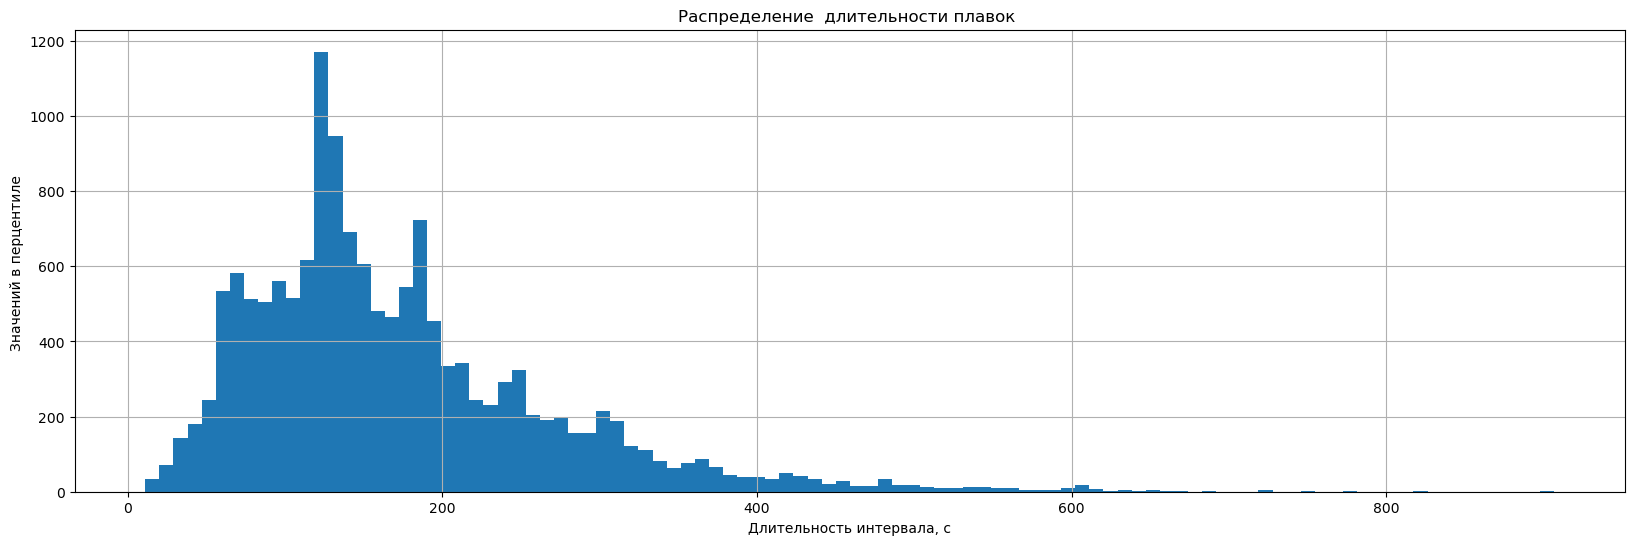

In [13]:
%%time
q_arc = """
select da.key,da."BeginHeat",da."EndHeat",da."ActivePower" act,da."ReactivePower" react,
  extract('epoch' from da."EndHeat"-da."BeginHeat") seconds 
  from steel.data_arc da 
"""
df_arc = pd.read_sql_query(q_arc, con=engine) 
print(df_arc[-df_arc.seconds>3600*4].shape[0] )
df_arc = df_arc[-df_arc.seconds<3600*4]
df_arc.seconds.hist(bins=100,figsize= (20,6));
plt.title('Распределение  длительности плавок ')
plt.xlabel('Длительность интервала, с')
plt.ylabel('Значений в перцентиле ')

Длительность плавки распределена примерно по Пуассону с резкими пиками вблиза максимума. 
Хвост образуют 10 плавок с длительностью 600-1000 секунд, не вижу признаков, что это какая-то аномалия

In [14]:
df_arc[df_arc.seconds > 600].sort_values(by='seconds',ascending = False).head(10)

,key,BeginHeat,EndHeat,act,react,seconds
7799,1689,18:49:03,19:04:10,3.731596,2.676388,907.0
12425,2701,06:11:16,06:25:02,3.150762,2.397032,826.0
7433,1616,09:07:06,09:20:06,2.943082,1.998065,780.0
2940,640,01:25:40,01:38:06,2.766592,2.236813,746.0
4655,1005,05:59:14,06:11:19,2.975003,2.006356,725.0
2662,580,18:06:25,18:18:29,2.940772,2.211983,724.0
9227,2001,20:19:15,20:31:16,3.156276,2.504206,721.0
14200,3086,03:41:09,03:53:10,3.052813,2.216230,721.0
11741,2560,06:02:36,06:14:37,2.991186,2.099555,721.0
10976,2387,06:27:55,06:39:20,2.999812,2.197359,685.0


Мощность загрузки распределена естествнным образом.  
Единственной аномалией является большая отрицательная реактивная мощность для одной партии, её лучше исключить при загрузке  

In [15]:
df_arc[(df_arc.act<0) | (df_arc.react<0)  ]

,key,BeginHeat,EndHeat,act,react,seconds
9781,2116,00:44:48,00:46:37,0.495782,-715.504924,109.0


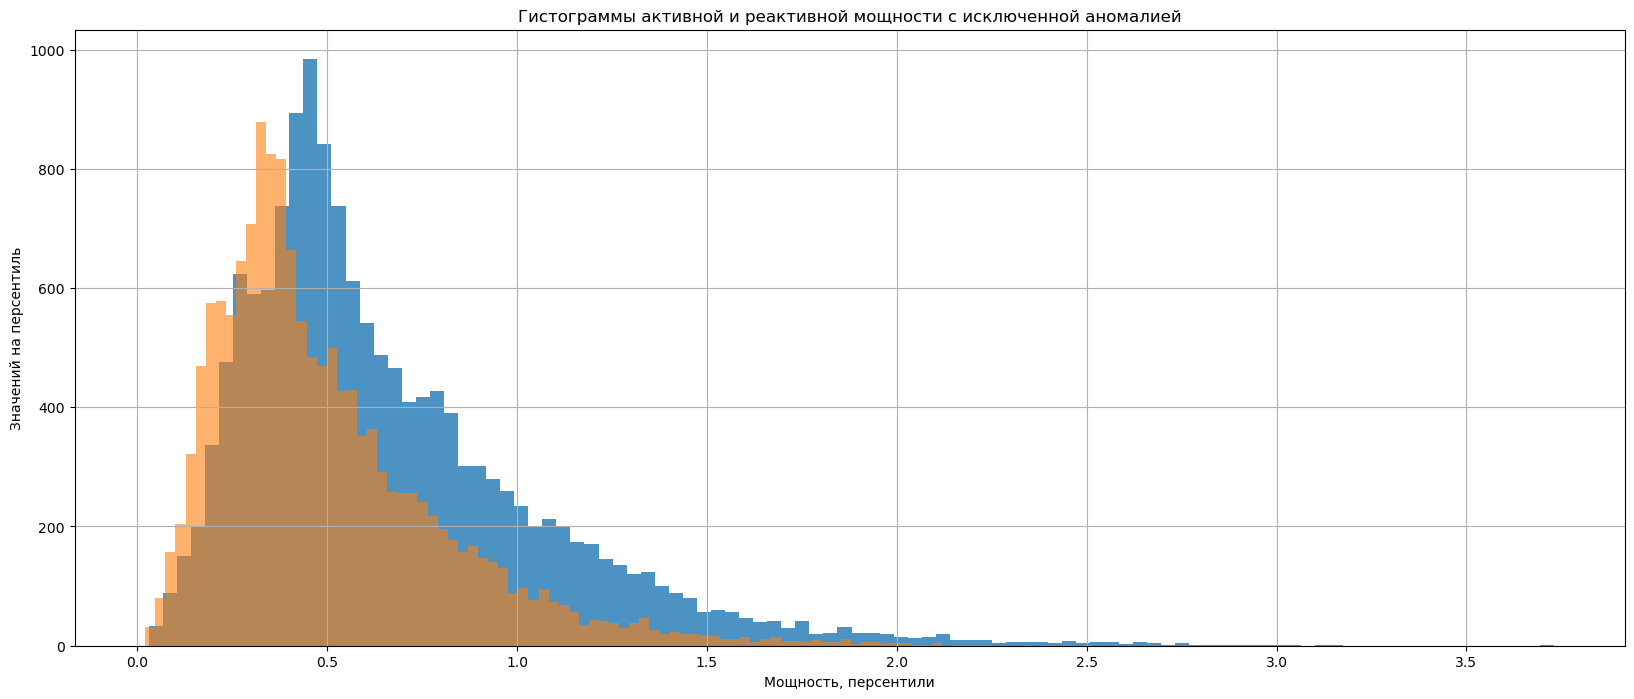

In [16]:
df_arc = df_arc[(df_arc.act>=0)&(df_arc.react>=0)]
df_arc.act.hist(bins=100,alpha=.8,figsize =(20,8));
df_arc.react.hist(bins=100,alpha=.6);
plt.xlabel('Мощность, персентили');
plt.ylabel('Значений на персентиль');
plt.title('Гистограммы активной и реактивной мощности с исключенной аномалией');
plt.show()

#### Таблицы загрузки материалов 

Про таблицы bulk/wire можно сказать только что
- все записи для партий на месте и там есть хотя бы одна загрузка для каждой партии
- очень много пустых значений, поэтому по самим данным таблицы ничего о них сказать нельзя
Более подробный анализ можно провести после загрузки данных в общий фрейм и сопоставлении их с другими

In [17]:
%%time
q_bulk = """
select *  
  from steel.data_bulk db 
  join steel.data_bulk_time dbt using(key); 
"""
df_bulk = pd.read_sql_query(q_bulk, con=engine) 
df_bulk.info()
pd.concat( [df_bulk.head(),df_bulk.sample(10),df_bulk.tail()] )


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 31 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
 16  Bulk 1   252 non-null    object 
 17  Bulk 2   22 non-null     object 
 18  Bulk 3   1298 non-null   object 
 19  Bulk 4   1014 non-null   object 
 20  Bulk 5   77 non-null     object 
 21  Bulk 6   576 n

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,...,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,11:03:52,None,11:03:52,11:03:52
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,11:40:20,None,11:40:20,11:40:20
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,12:09:40,None,12:09:40,12:09:40
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,12:41:24,None,12:41:24,12:41:24
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,13:12:56,None,13:12:56,13:12:56
254,271,27.0,NaN,49.0,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,14:34:24,None,14:34:24,14:34:24
1814,1875,NaN,NaN,95.0,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,23:45:47,None,23:45:47,23:45:47
48,57,27.0,NaN,NaN,NaN,NaN,109.0,NaN,NaN,NaN,...,10:25:10,None,None,None,None,None,10:02:49,None,10:02:49,10:02:49
1019,1064,27.0,NaN,87.0,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,08:02:29,None,08:02:29,08:02:29
1327,1375,NaN,NaN,87.0,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,01:15:07,None,01:15:07,01:15:07


In [18]:
%%time
q_wire = """
select *  
  from steel.data_wire dw
  join steel.data_wire_time dwt using(key); 
"""
df_wire = pd.read_sql_query(q_wire, con=engine) 
df_wire.info()
pd.concat( [df_wire.head(),df_wire.sample(10),df_wire.tail()] )


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
 10  Wire 1  3055 non-null   object 
 11  Wire 2  1079 non-null   object 
 12  Wire 3  63 non-null     object 
 13  Wire 4  14 non-null     object 
 14  Wire 5  1 non-null      object 
 15  Wire 6  73 non-null     object 
 16  Wire 7  11 non-null     object 
 17  Wire 8  19 non-null     object 
 18  Wire 9  29 non-null     object 
dtypes: float64(9), int64(1), object(9)
memory usage: 457.5+ KB
CPU times: user 9.2 ms, sys: 8.58 ms, total: 17.8 ms

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11:11:41,None,None,None,None,None,None,None,None
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11:46:10,None,None,None,None,None,None,None,None
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12:13:47,None,None,None,None,None,None,None,None
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12:48:05,None,None,None,None,None,None,None,None
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13:18:15,13:32:06,None,None,None,None,None,None,None
1175,1243,202.503604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,07:49:02,None,None,None,None,None,None,None,None
84,99,70.106400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19:42:35,None,None,None,None,None,None,None,None
2655,2794,132.437759,9.198800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20:43:56,20:55:04,None,None,None,None,None,None,None
2121,2229,97.144318,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14:32:35,None,None,None,None,None,None,None,None
992,1052,154.159195,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22:06:16,None,None,None,None,None,None,None,None


#### Общие выводы по результатам анализа БД

* Серьезным недостатком набора данных является отсутствие привязки к дате, из-за чего восстановление хронологии при переходе границы суток затруднено, а при увеличении длятельности процессов загрузка может даже работать некорректно 
* Почти четверть партий содержит только одно валидное измерение, из-за чего они бесполезны для моделирования
* Есть рассинхронизация между сериями измерений и реальными операциями
* Без привяки к измерениям температуры , сами по себе данные о плавках и добавках непротиворечивы, сбалансированы и содержат лишь единичные выбросы
* Значения температуры распределны нормально в узком диапазоне, что позволяет надеяться на предсказания с достаточноы высокой точностью

### Рабочая загрузка

Все данные загружаются в один фрейм , где строка соответствует одной партии.   
Загрузки материалов (data_bulk) и газа уже имеют подходящую организацию с уникальным номером партии ,
поэтому их можно просто объединить по ключу партии (key) 

Я стремился уже при згрузке отсечь как можно больше лишних данных и провести по возомжности больше преобразований, 
чтобы не растаскивать различные датафреймы по проекту и не путаться в них.  
Так, все время сразу при загрузке перевозится  в секунды относительно первого измерения температуры,   
так как их все равно надо преобразовывать в числа для моделей 
Сама колонка  времени первого измерения <b>begin_time</b> остается time, но она только для ориентировки и в расчетах не используется.

Так как придется выполнять с колонками разшичные групповые операции, их имена подобраны для удобства такой группировки.  
Имя колонки состоит из двухбуквенного префикса, определяющего её тип , подчеркивания и номера.   
Первая буква префикса - <b>m</b> для "материальных колонок " и  <b>t</b> - для "временных"   
Вторая буква префикса - <b>b, w</b> или <b>g</b> - показывает таблицу - источник данных (bulk/wire/gas) 

Наконец, создаются специальные колонки   
<b>m_temp</b> - первое изменение температуры 
<b>y_temp</b> - цель - последнее изменение температуры 

In [19]:
bulk_clause =", ".join([f'b."Bulk {i}" mb_{i}, \
    extract("epoch" from bt."Bulk {i}")-extract("epoch" from begin_time) tb_{i}' 
                        for i in range(1,16)])
wire_clause =", ".join([f'w."Wire {i}" mw_{i}, \
    extract("epoch" from wt."Wire {i}") - extract("epoch" from begin_time) tw_{i}' 
                        for i in range(1,10)])

q_bulk_wire = f"""
  select key,gas m_gas,
    {bulk_clause},
    {wire_clause},
    m_temp,t_temp,y_temp,begin_time,qty_temp
  from steel.data_bulk b  
  join steel.data_bulk_time bt using(key)
  join steel.data_wire w using(key)
  join steel.data_wire_time wt using(key)
  join steel.data_gas g using(key)
  join ( {correct_temp_clause}
    ) temp_agg using(key)
 order by key,begin_time desc
"""
f_bulk_wire = pd.read_sql_query(q_bulk_wire, con=engine) 
f_bulk_wire.info()
pd.concat( [f_bulk_wire.head(),f_bulk_wire.sample(10),f_bulk_wire.tail()] )


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2275 entries, 0 to 2274
Data columns (total 55 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         2275 non-null   int64  
 1   m_gas       2275 non-null   float64
 2   mb_1        194 non-null    float64
 3   tb_1        194 non-null    float64
 4   mb_2        13 non-null     float64
 5   tb_2        13 non-null     float64
 6   mb_3        940 non-null    float64
 7   tb_3        940 non-null    float64
 8   mb_4        796 non-null    float64
 9   tb_4        796 non-null    float64
 10  mb_5        49 non-null     float64
 11  tb_5        49 non-null     float64
 12  mb_6        424 non-null    float64
 13  tb_6        424 non-null    float64
 14  mb_7        13 non-null     float64
 15  tb_7        13 non-null     float64
 16  mb_8        1 non-null      float64
 17  tb_8        1 non-null      float64
 18  mb_9        12 non-null     float64
 19  tb_9        12 non-null    

,key,m_gas,mb_1,tb_1,mb_2,tb_2,mb_3,tb_3,mb_4,tb_4,...,tw_7,mw_8,tw_8,mw_9,tw_9,m_temp,t_temp,y_temp,begin_time,qty_temp
0,1,29.749986,NaN,NaN,NaN,NaN,NaN,NaN,43.0,312.0,...,NaN,NaN,NaN,NaN,NaN,1571.0,861.0,1613.0,11:16:18,5
1,2,12.555561,NaN,NaN,NaN,NaN,NaN,NaN,73.0,551.0,...,NaN,NaN,NaN,NaN,NaN,1581.0,1305.0,1602.0,11:37:27,6
2,3,28.554793,NaN,NaN,NaN,NaN,NaN,NaN,34.0,1069.0,...,NaN,NaN,NaN,NaN,NaN,1596.0,1300.0,1599.0,12:13:17,5
3,4,18.841219,NaN,NaN,NaN,NaN,NaN,NaN,81.0,-254.0,...,NaN,NaN,NaN,NaN,NaN,1601.0,388.0,1625.0,12:52:57,3
4,5,5.413692,NaN,NaN,NaN,NaN,NaN,NaN,78.0,-269.0,...,NaN,NaN,NaN,NaN,NaN,1576.0,762.0,1602.0,13:23:19,2
227,266,2.694759,NaN,NaN,NaN,NaN,74.0,524.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1567.0,1524.0,1591.0,07:52:08,5
1787,1954,8.898159,NaN,NaN,NaN,NaN,166.0,775.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1632.0,1754.0,1594.0,18:15:33,5
878,981,8.652169,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1619.0,1237.0,1611.0,09:40:41,3
328,383,15.112151,NaN,NaN,NaN,NaN,NaN,NaN,73.0,1015.0,...,NaN,NaN,NaN,NaN,NaN,1618.0,2305.0,1595.0,18:51:25,4
672,749,16.433918,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1593.0,1177.0,1589.0,03:35:53,4


Для каждой плавки создается отдельный набор колонок -   
начало и конец плавки(<b>th* ,te* </b>), 
активная и реактивная мощности(<b> ma* , mr* </b>).  
При этом выдерживаются правила наименованимя колонок <b>m/t</b>

Чтобы развернуть таблицу плавок во фреймы,  
сначала присваиваем каждой ранг по времени в пределах ключа,   
затем для каждого ранга созаетм группу колонок.

In [20]:
max_melts = 15
arc_clause = ', '.join([
f"min( case when rk={i} then begin_heat end) th_{i},\
min( case when rk={i} then end_heat end) te_{i},\
sum(case when rk={i} then pa end) ma_{i},\
sum( case when rk={i} then pr end) mr_{i}"
for i in range(1,max_melts+1)])

arc_temp_clause = ", ".join([
    f"ma_{i},mr_{i},\
    extract('epoch' from th_{i}-begin_time) th_{i},\
    extract('epoch' from te_{i}-begin_time) te_{i}"
for i in range(1,max_melts+1)])

q_arc=f"""
select key,begin_time,t_temp,
    {arc_temp_clause}
    from (
      select key,
        {arc_clause}
        from(
            select key,a0."BeginHeat" begin_heat,a0."EndHeat" end_heat,
               a0."ActivePower" pa, a0."ReactivePower" pr,
               cast( rank()  over( partition by key order by a0."BeginHeat" ) as integer) rk 
              from steel.data_arc a0 
             where a0."ActivePower" >=0 and a0."ReactivePower" >=0
       ) a1
       group by key
     ) a 
 join ( {correct_temp_clause}
 ) temp_measure using(key)
 """
f_arc = pd.read_sql_query(q_arc, con=engine) 
f_arc.info()
pd.concat( [f_arc.head(),f_arc.sample(10),f_arc.tail()] )
 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2421 entries, 0 to 2420
Data columns (total 63 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         2421 non-null   int64  
 1   begin_time  2421 non-null   object 
 2   t_temp      2421 non-null   float64
 3   ma_1        2421 non-null   float64
 4   mr_1        2421 non-null   float64
 5   th_1        2421 non-null   float64
 6   te_1        2421 non-null   float64
 7   ma_2        2389 non-null   float64
 8   mr_2        2389 non-null   float64
 9   th_2        2389 non-null   float64
 10  te_2        2389 non-null   float64
 11  ma_3        2253 non-null   float64
 12  mr_3        2253 non-null   float64
 13  th_3        2253 non-null   float64
 14  te_3        2253 non-null   float64
 15  ma_4        1864 non-null   float64
 16  mr_4        1864 non-null   float64
 17  th_4        1864 non-null   float64
 18  te_4        1864 non-null   float64
 19  ma_5        1185 non-null  

,key,begin_time,t_temp,ma_1,mr_1,th_1,te_1,ma_2,mr_2,th_2,...,th_13,te_13,ma_14,mr_14,th_14,te_14,ma_15,mr_15,th_15,te_15
0,1,11:16:18,861.0,0.976059,0.687084,-844.0,-616.0,0.805607,0.520285,-530.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,11:37:27,1305.0,0.438063,0.283043,-193.0,-56.0,1.296415,0.892914,83.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,12:13:17,1300.0,1.062053,0.671494,-383.0,-103.0,0.484206,0.312100,35.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,12:52:57,388.0,0.875313,0.614404,-800.0,-593.0,0.425692,0.268482,-490.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,13:23:19,762.0,0.950026,0.690523,-726.0,-475.0,0.508026,0.332352,-298.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
936,974,04:23:59,1073.0,0.598566,0.440897,-193.0,-46.0,0.745527,0.544929,208.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1571,1625,15:15:30,1221.0,0.461401,0.388937,-180.0,-38.0,0.600347,0.416797,242.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2169,2236,21:27:06,2408.0,0.477045,0.366446,-281.0,-146.0,0.951272,0.747361,418.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002,2066,01:46:38,3032.0,0.431668,0.337729,-179.0,-54.0,0.940706,0.749985,168.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1663,1720,12:41:04,2642.0,0.698222,0.457046,-277.0,-64.0,0.673718,0.654839,210.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Объединение данных для моделирования 

In [21]:
df = f_bulk_wire.merge(f_arc, on=['key','begin_time','t_temp'])

Создаем группы колонок в соответствии с правилами наименований.  
Для исследований создаем группы tier1,tier2,tier3 в соотсвтествие с колчичеством непустых значений в этих колонках  
Наконец для искуственных целочисленных признаков создается группа int_cols -   
пока в ней только количество плавок.

Все колнки используются как признаки, кроме begin_time и целевой y_temp 

In [22]:
magni_cols = [c for c in df.columns if c[0]=='m']
time_cols = [c for c in df.columns if c[0]=='t']

tier1_cols = [ c for c in magni_cols+time_cols if df[c].notna().sum()>=1_000 ]
magni1_cols = [ c for c in magni_cols if c in tier1_cols ]
time1_cols = [ c for c in time_cols if c in tier1_cols ]

tier2_cols = [ c for c in magni_cols+time_cols if 100 <= df[c].notna().sum()<1_000 ]
magni2_cols = [ c for c in magni_cols if c in tier2_cols ]
time2_cols = [ c for c in time_cols if c in tier2_cols ]

tier3_cols = [ c for c in magni_cols+time_cols if 1 <= df[c].notna().sum()<100 ]
begin_heat_cols = [ c for c in time_cols if c[1]=='h' ]
end_heat_cols = [ c for c in time_cols if c[1]=='e' ]
bulk_time_cols = [c for c in df.columns if c[:2]=='tb']
wire_time_cols = [c for c in df.columns if c[:2]=='tw']
bulk_cols = [c for c in df.columns if c[:2]=='mb']
wire_cols = [c for c in df.columns if c[:2]=='mw']
active_cols = [c for c in df.columns if c[:2]=='ma']
reactive_cols = [c for c in df.columns if c[:2]=='mr']

int_cols = [c for c in df.columns if c[:3]=='num']

null_cols = [ c for c in magni_cols+time_cols if  df[c].notna().sum() ==0 ]
null_cols


['mw_5', 'tw_5']

Колонки mw_5 tw_5 опустели после очистки фрейма от партий с одним замером  
Я их удалю позже, чтобы не нарушать целостность скриптов (которые перебирают все признаки по номерами)

#### Корректировка временных интервалов

При приведении к секундам в запросе естсественно получаются значения в районе +-84_000 вследстие суточных переходов.  
Так как у нас нет объектов с временами больше  6 часов, мы можем быть уверены, что это именно суточные переходы и восстановить нормальные значения просто отняв/добавив 84_000 

In [23]:
def fix_24h_gaps(t):
    if t is not None:
        if t < -12*3600:
            t += 24*3600
        elif t> 12*3600:
            t -= 24*3600
    return t 

for c in time_cols:
    df[c] = df[c].apply(fix_24h_gaps )

Есть операции(в основном плавки) проведенные после последнего измерения температуры.   
Объектино они не влияют на резултьтат, но вносят шум в модель, поэтому я считаю правильным их стереть.

In [24]:
def fix_beyond_measures(row):  
    for i in range(1,len(bulk_time_cols)+1):
        if row[f"tb_{i}"] is not None:
            if row[f"tb_{i}"]>row["t_temp"]:
                row[f"tb_{i}"]=None
                row[f"mb_{i}"]=None
    for i in range(1,len(wire_time_cols)+1):
        if row[f"tw_{i}"] is not None:
            if row[f"tw_{i}"]>row["t_temp"]:
                row[f"tw_{i}"]=None
                row[f"mw_{i}"]=None
    for i in range(1,len(begin_heat_cols)+1):
        if row[f"th_{i}"] is not None:
            if row[f"th_{i}"]>row["t_temp"]:
                row[f"th_{i}"]=None
                row[f"te_{i}"]=None        
                row[f"ma_{i}"]=None
                row[f"mr_{i}"]=None  
            
    return row

df = df.apply(fix_beyond_measures,axis=1)

Что касвется операций до первого измерения, то на итоговую темпетратуру, они в принципе могут влиять ,
по крайней мере легирующие добавки меняют  свойства сплава ( теплоемкость и теплопроводность).   
Обычные плавки вроде влиять не должны, но вообще тут лучше на всякий случай советоваться с технологами .   
Пока я решил их оставить.    

In [25]:
num_melts = df[begin_heat_cols].notna().astype(int).sum(axis=1)
df = pd.concat([df,pd.Series( num_melts, name= 'num_melts')],axis=1) 
int_cols = [c for c in df.columns if c[:3]=='num']

Проверим что партий без плавок нет

In [26]:
df[df.num_melts == 0][begin_heat_cols]

,th_1,th_2,th_3,th_4,th_5,th_6,th_7,th_8,th_9,th_10,th_11,th_12,th_13,th_14,th_15


## Проверка загруженных данных

#### Проверка аномалий в объединенном фрейме

In [27]:
df.y_temp.agg(['max','min','count','mean','std'])

max      1653.000000
min      1541.000000
count    2275.000000
mean     1593.384176
std        11.174561
Name: y_temp, dtype: float64

Параметры распределения целевого   признака не изменились 

У нас всего 2200 записей (т.е меньше 2000 для обучения), так что трудно определить являются экстремальные значения выбросами или вариантом нормы. Проверим признаки из tier1 , где записей достаточно много 

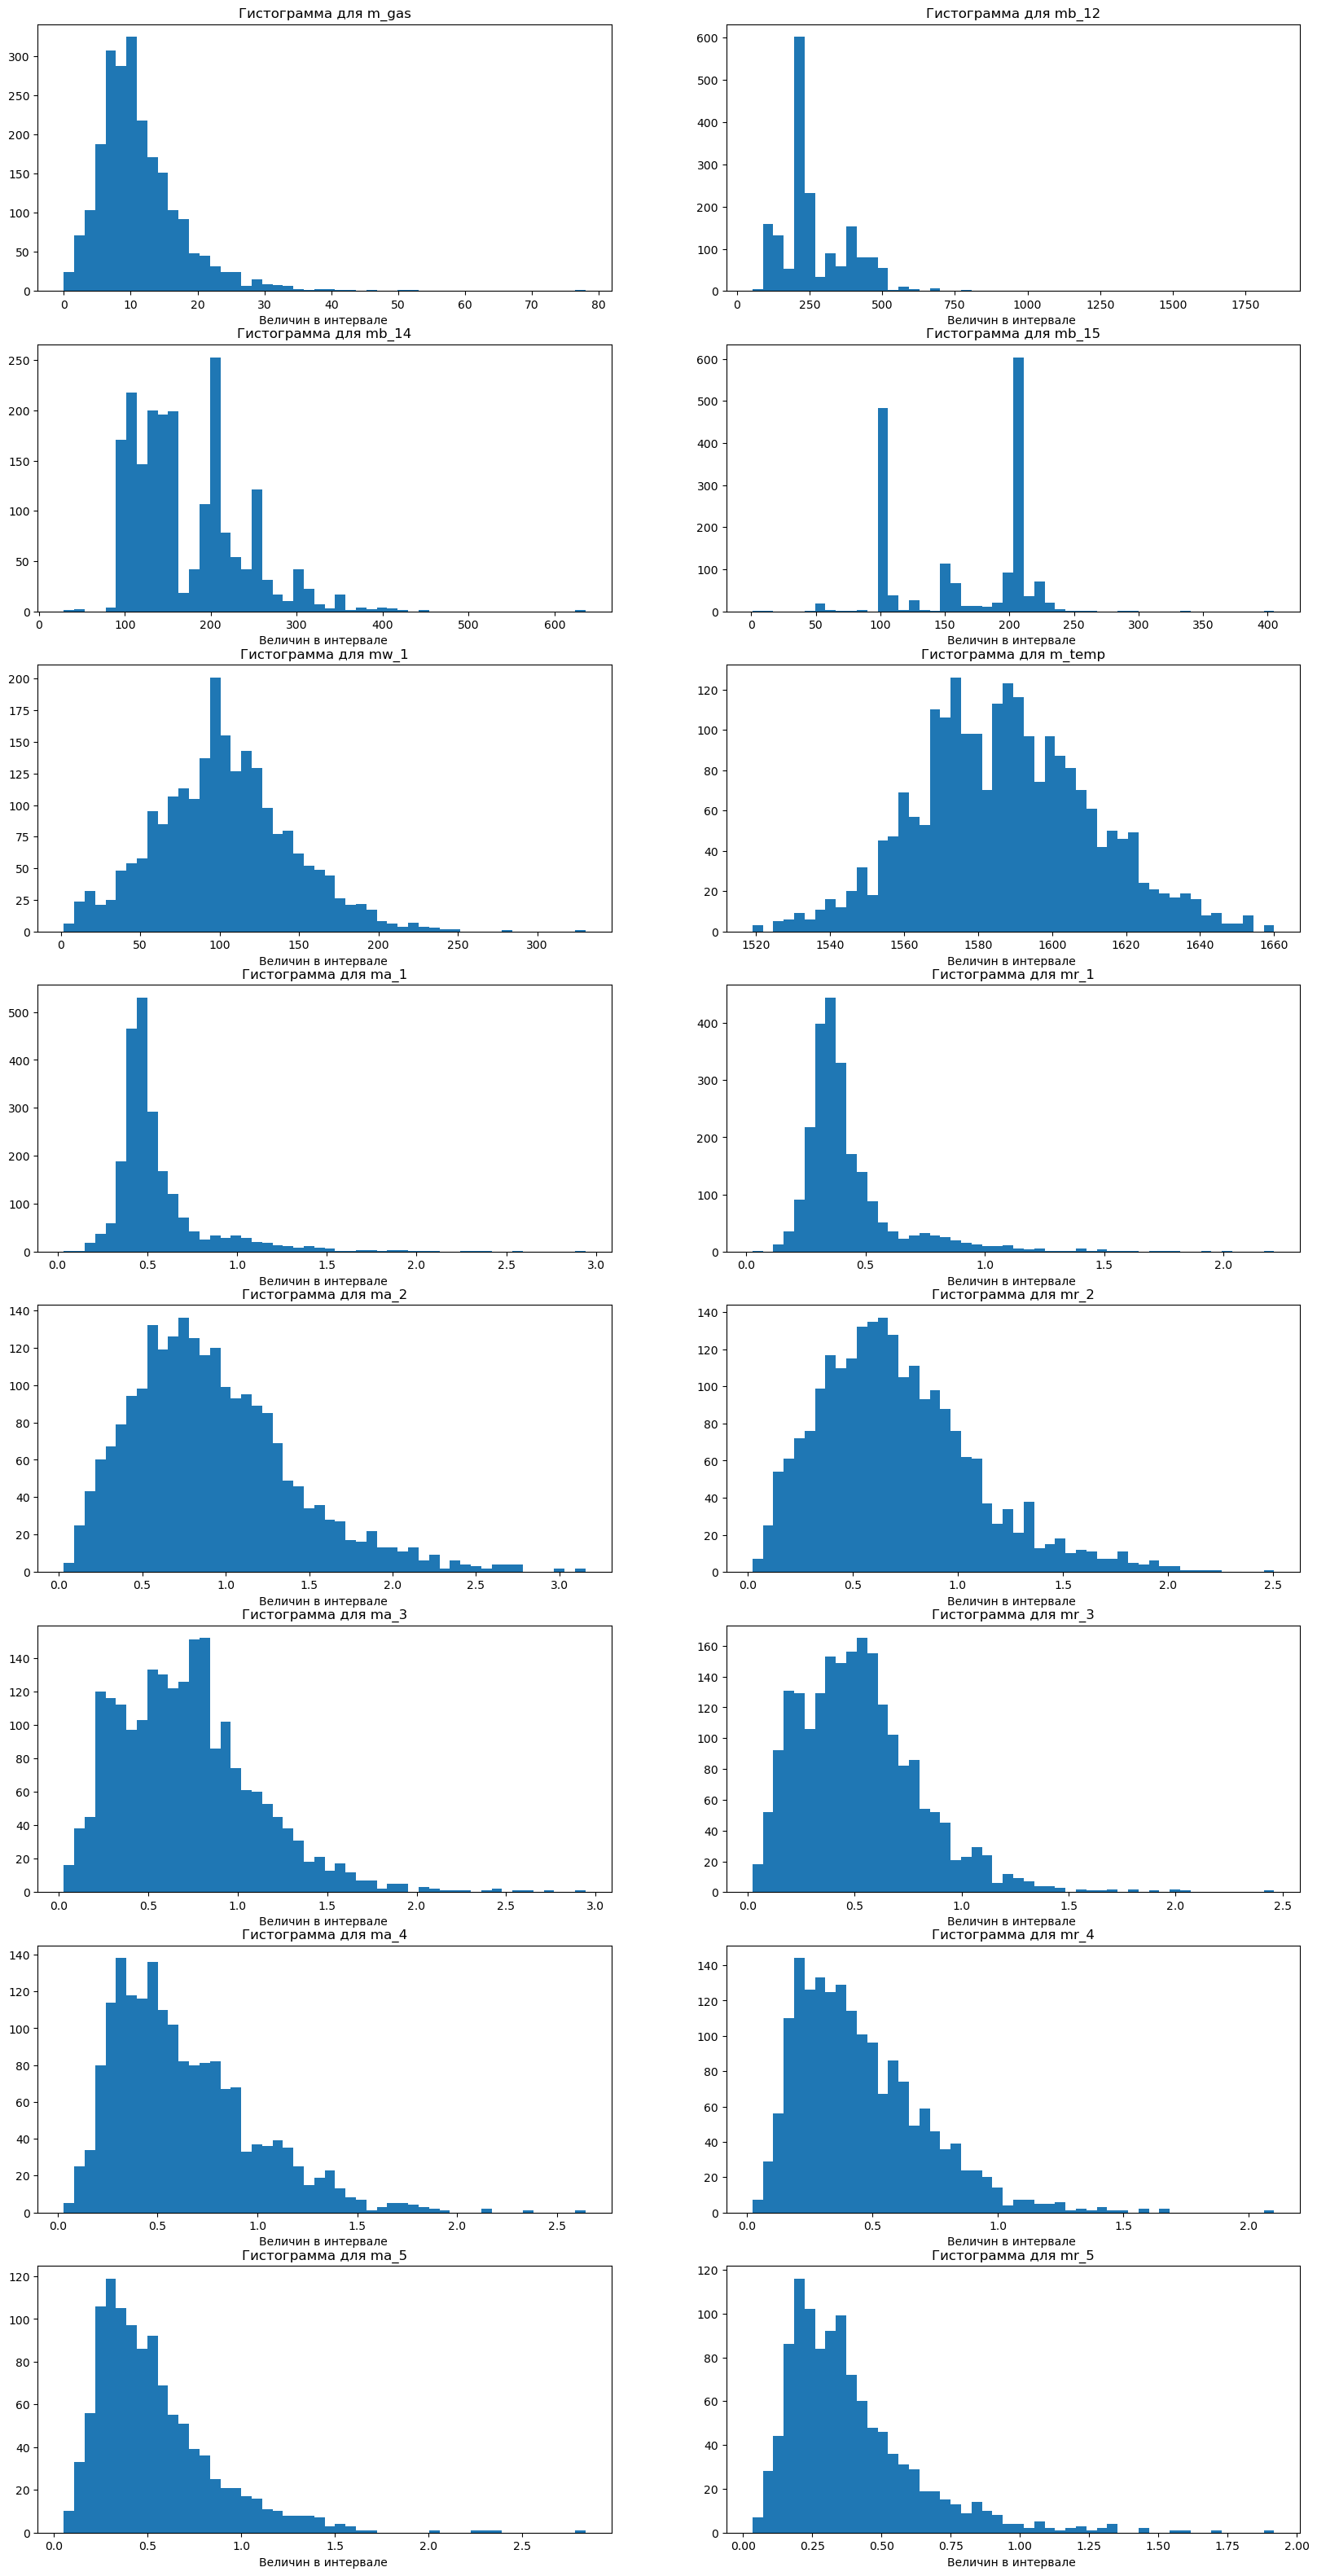

In [28]:
grid_rows = (len(magni1_cols)+1)//2
fig,axs = plt.subplots( grid_rows,2 , figsize=(20,5*grid_rows) )
for i in range(len(magni1_cols)):
    c = magni1_cols[i]           
    ax = axs[i//2,i%2]
    ax.hist(df[c],bins=50)
    ax.set_title(f'Гистограмма для {c}')
    ax.set_xlabel(f"Значения {c}, с интервалом 2% ")
    ax.set_xlabel(f"Величин в интервале ")
plt.show()

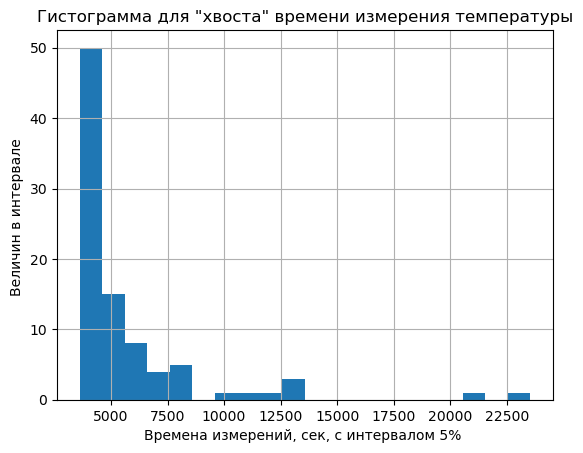

In [29]:
df[df.t_temp>3600].t_temp.hist(bins=20);
plt.title(f'Гистограмма для "хвоста" времени измерения температуры')
plt.xlabel(f"Времена измерений, сек, с интервалом 5% ")
plt.ylabel(f"Величин в интервале ")
plt.show()

Судя по гистограммам , сильные выбросы есть только для t_temp(время финального измерения температуры) и mb_12  
Выборка данных показывает, что это реальные процессы, а не сбой в данных и там согласованно меняются несколько параметров.
Корректировать их бессмысленно, и я не вижу оснований, чтобы уверенно их удалять.

In [30]:
df[df.mb_12>500][magni1_cols].sort_values(by='mb_12',ascending=False).head(30)

,m_gas,mb_12,mb_14,mb_15,mw_1,m_temp,ma_1,mr_1,ma_2,mr_2,ma_3,mr_3,ma_4,mr_4,ma_5,mr_5
279,77.995040,1849.0,636.0,NaN,NaN,1619.0,0.518544,0.382905,0.801966,0.582975,1.019583,0.815634,0.294657,0.212946,0.451133,0.363475
1826,7.815190,853.0,366.0,290.0,100.070877,1650.0,0.447065,0.382034,0.374652,0.351387,0.968894,0.859054,0.625355,0.476386,0.230362,0.157757
1656,23.488170,833.0,249.0,NaN,236.667587,1590.0,0.640420,0.426116,0.944198,0.646503,1.302291,1.014504,0.813074,0.565738,0.803872,0.678355
284,4.898431,775.0,403.0,205.0,97.016404,1572.0,0.427006,0.308683,1.169977,0.932679,1.139595,1.001114,0.790179,0.596116,0.744057,0.522543
1332,43.655411,774.0,306.0,100.0,280.987214,1567.0,0.567267,0.427851,1.892718,1.718930,0.916578,0.793427,NaN,NaN,NaN,NaN
1539,33.597044,733.0,248.0,224.0,187.153206,1583.0,0.337803,0.242150,1.230050,0.809881,1.211215,0.852895,0.857824,0.559878,0.605553,0.394115
2107,1.658822,685.0,199.0,206.0,45.077759,1541.0,0.533725,0.424341,2.668096,1.754383,1.179005,0.774032,0.777793,0.505913,NaN,NaN
388,28.482189,671.0,379.0,203.0,168.339600,1594.0,0.526707,0.346630,1.781754,1.510546,1.045433,0.878578,0.361857,0.292142,NaN,NaN
787,22.806671,669.0,102.0,NaN,185.561982,1591.0,0.482443,0.317078,1.489824,1.237689,0.462705,0.363727,0.765115,0.522780,0.602536,0.381190
899,3.807152,668.0,198.0,205.0,100.151993,1546.0,0.440596,0.332554,2.975003,2.006356,0.799800,0.511725,0.548441,0.361767,NaN,NaN


In [31]:
df[df.t_temp>7200][time1_cols].sort_values(by='t_temp',ascending=False)

,tb_12,tb_14,tb_15,tw_1,t_temp,th_1,te_1,th_2,te_2,th_3,te_3,th_4,te_4,th_5,te_5
1539,292.0,292.0,292.0,1021.0,23537.0,-167.0,-70.0,118.0,440.0,645.0,928.0,1363.0,1558.0,1852.0,1989.0
1927,NaN,NaN,NaN,20467.0,20923.0,-223.0,-88.0,1348.0,1435.0,1721.0,1776.0,1849.0,1909.0,2070.0,2188.0
574,-168.0,-168.0,-168.0,17.0,12789.0,-257.0,-49.0,32.0,168.0,998.0,1089.0,4254.0,4379.0,4435.0,5048.0
716,99.0,99.0,11493.0,12197.0,12753.0,-197.0,-100.0,15.0,319.0,363.0,569.0,11061.0,11172.0,11311.0,11650.0
1717,178.0,178.0,178.0,424.0,12643.0,-282.0,-118.0,154.0,238.0,595.0,814.0,1258.0,1661.0,10555.0,10734.0
1716,1699.0,172.0,1699.0,407.0,11819.0,-194.0,-49.0,164.0,362.0,523.0,633.0,1015.0,1195.0,1320.0,1399.0
1380,188.0,188.0,188.0,465.0,10954.0,-390.0,-279.0,92.0,379.0,549.0,682.0,825.0,930.0,1179.0,1251.0
93,NaN,NaN,NaN,NaN,9598.0,-593.0,-358.0,769.0,838.0,1737.0,1796.0,7993.0,8244.0,8616.0,9253.0
1926,NaN,NaN,NaN,3456.0,8194.0,-189.0,-56.0,1553.0,1636.0,1914.0,2083.0,3083.0,3258.0,3337.0,3395.0
1145,NaN,240.0,240.0,443.0,7743.0,-179.0,-55.0,193.0,329.0,4786.0,4894.0,4996.0,5067.0,5198.0,5410.0


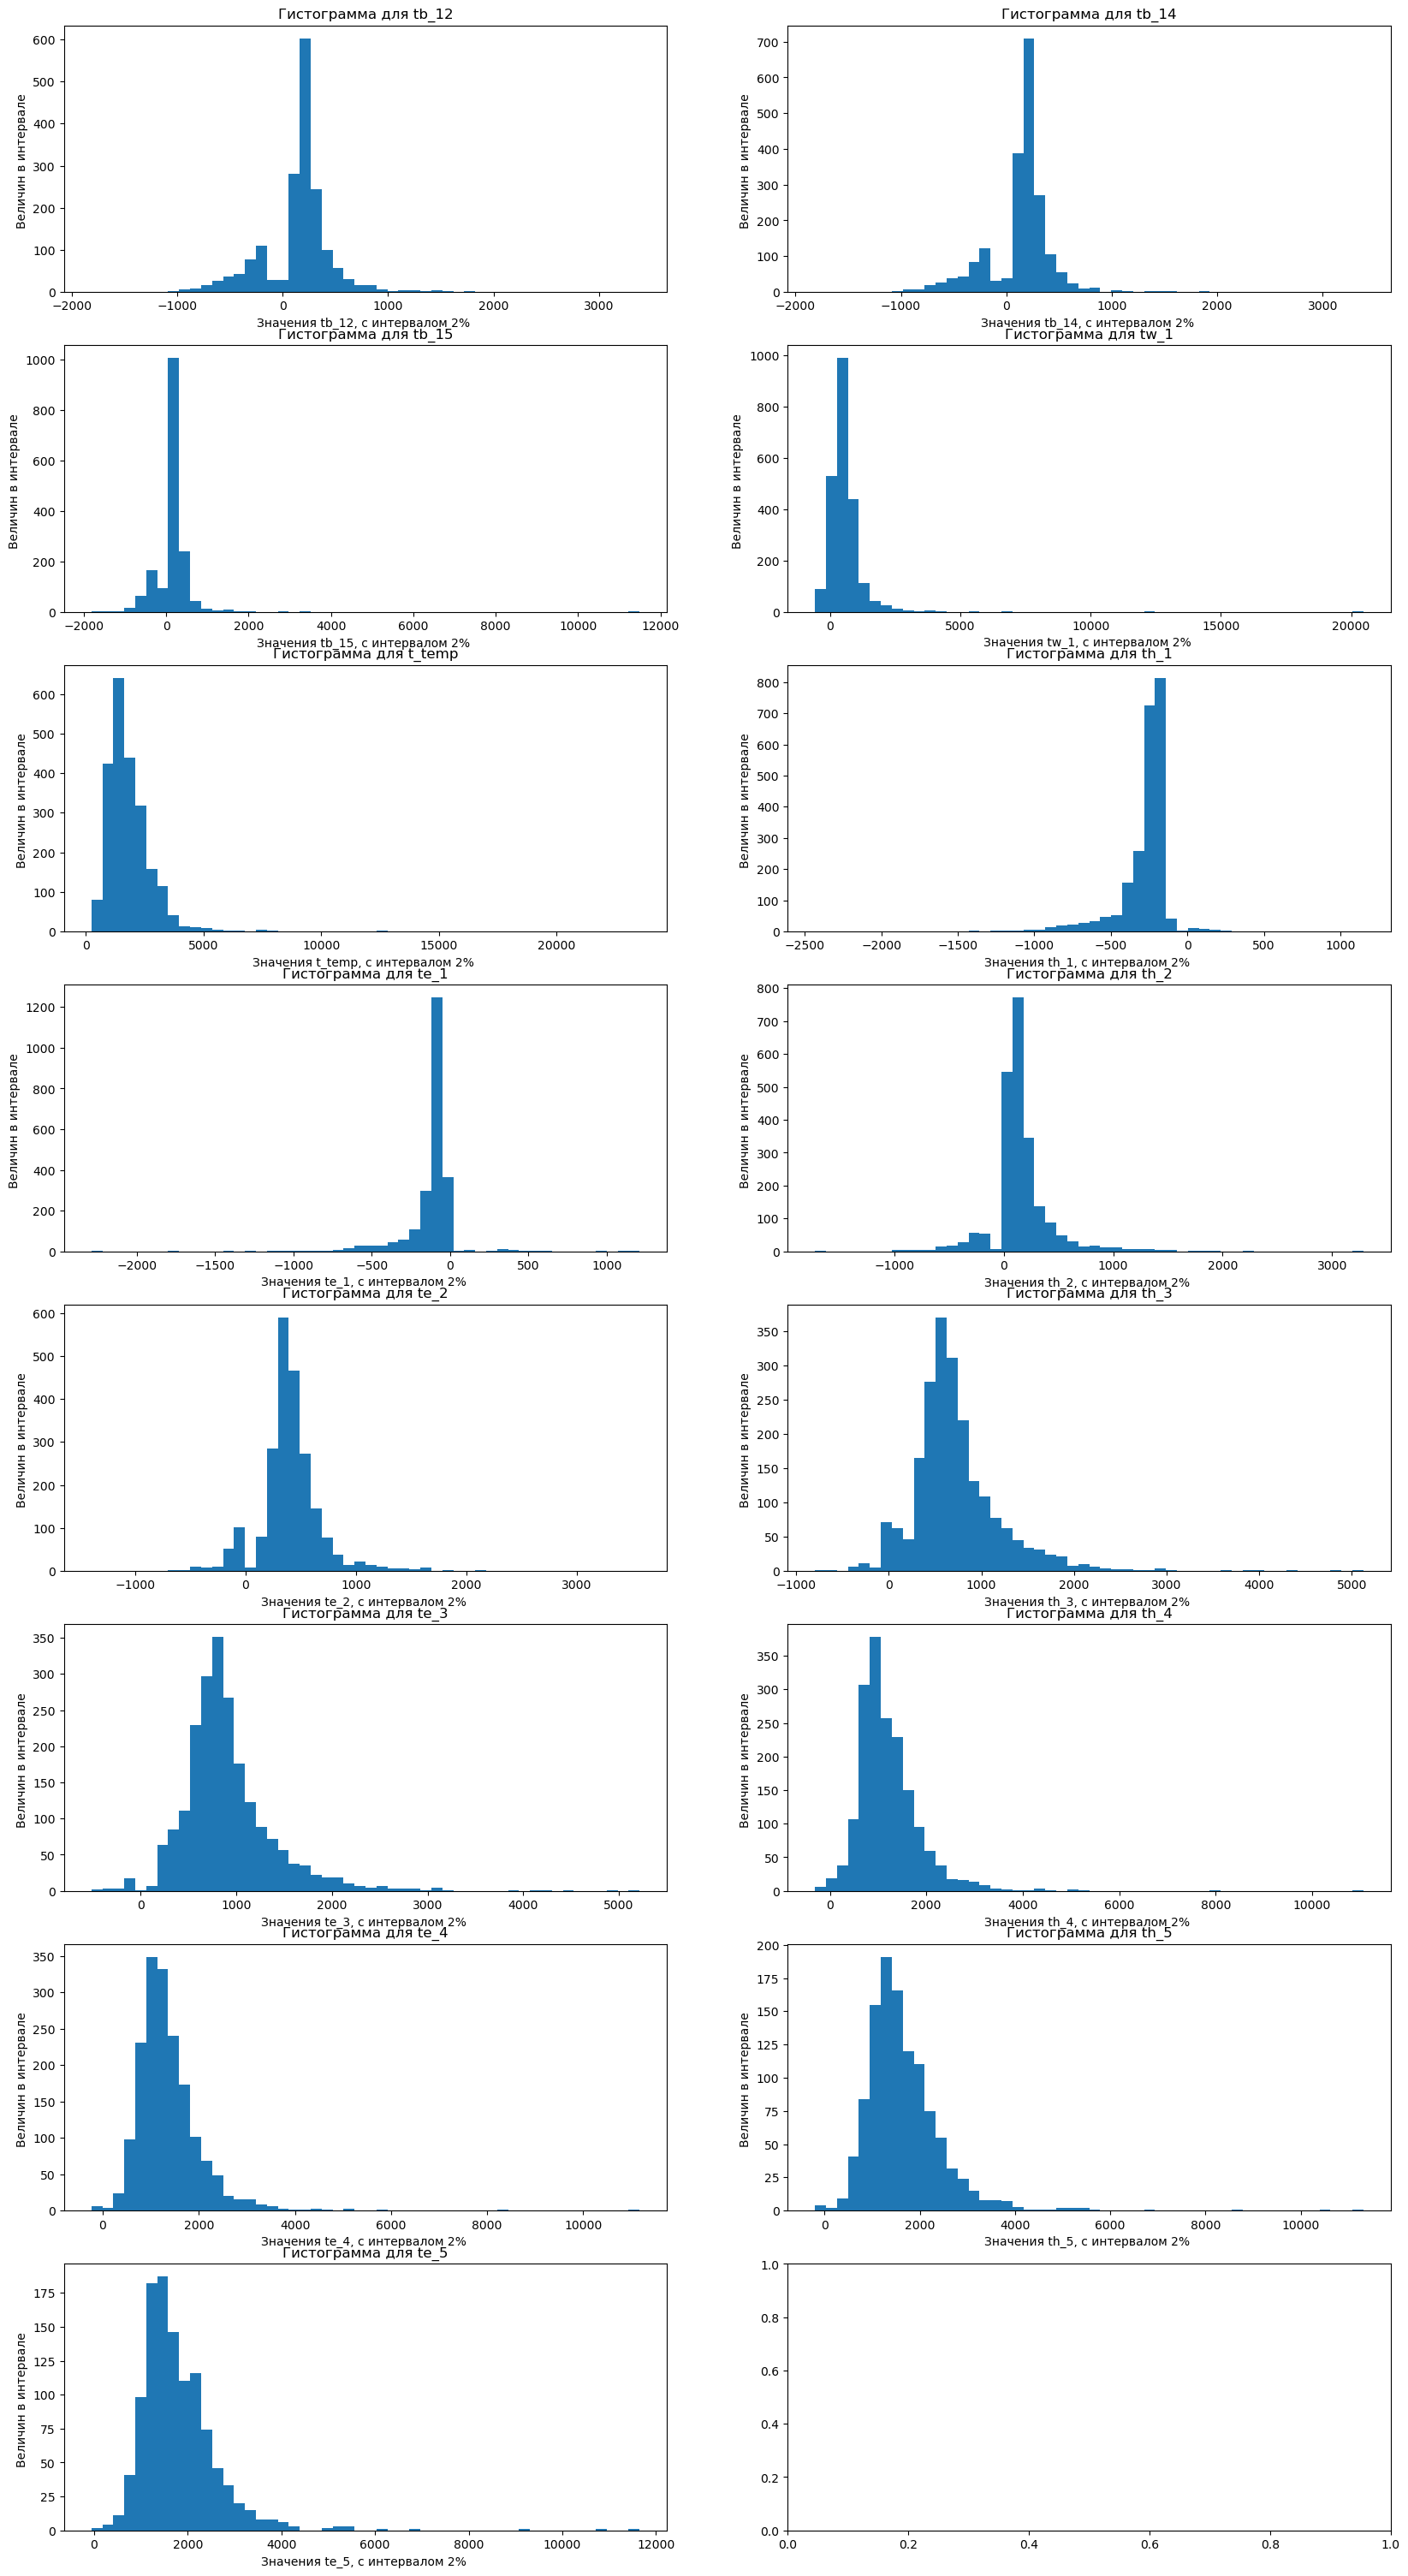

In [32]:
fig,axs = plt.subplots( len(time1_cols)//2+1,2 , figsize=(20,5*len(time1_cols)//2+1) )
for i in range(len(time1_cols)):
    c = time1_cols[i]           
    ax = axs[i//2,i%2]
    ax.hist(df[c],bins=50)
    ax.set_title(f'Гистограмма для {c}')
    ax.set_xlabel(f"Значения {c}, с интервалом 2% ")
    ax.set_ylabel(f"Величин в интервале ")
plt.show()

### Корреляции

Создадим инструментарий для показа тепловой карты и отбора ниболее коррелирующих пар

In [33]:
def show_heat_map(df, title, annotations = True):
    fig, ax = plt.subplots(figsize=(20,16))  
    sns.heatmap(df.corr(),
          annot=annotations,
          vmin=0,
          cmap=sns.color_palette("plasma", as_cmap=True),
          fmt = '.2f' , 
          ax= ax); 
    plt.title(title); 

In [34]:
def top_corr(df,num_rows = 10,ascending =False):
    df_corr =pd.melt( df.corr(),ignore_index=False).sort_values(by='value',ascending=ascending)
    df_corr = df_corr[df_corr.index> df_corr.variable]
    print( df_corr[df_corr.index!=df_corr.variable].head(num_rows) )
    

Признаки начал и концов плавок показывают очень высокую корреляцию

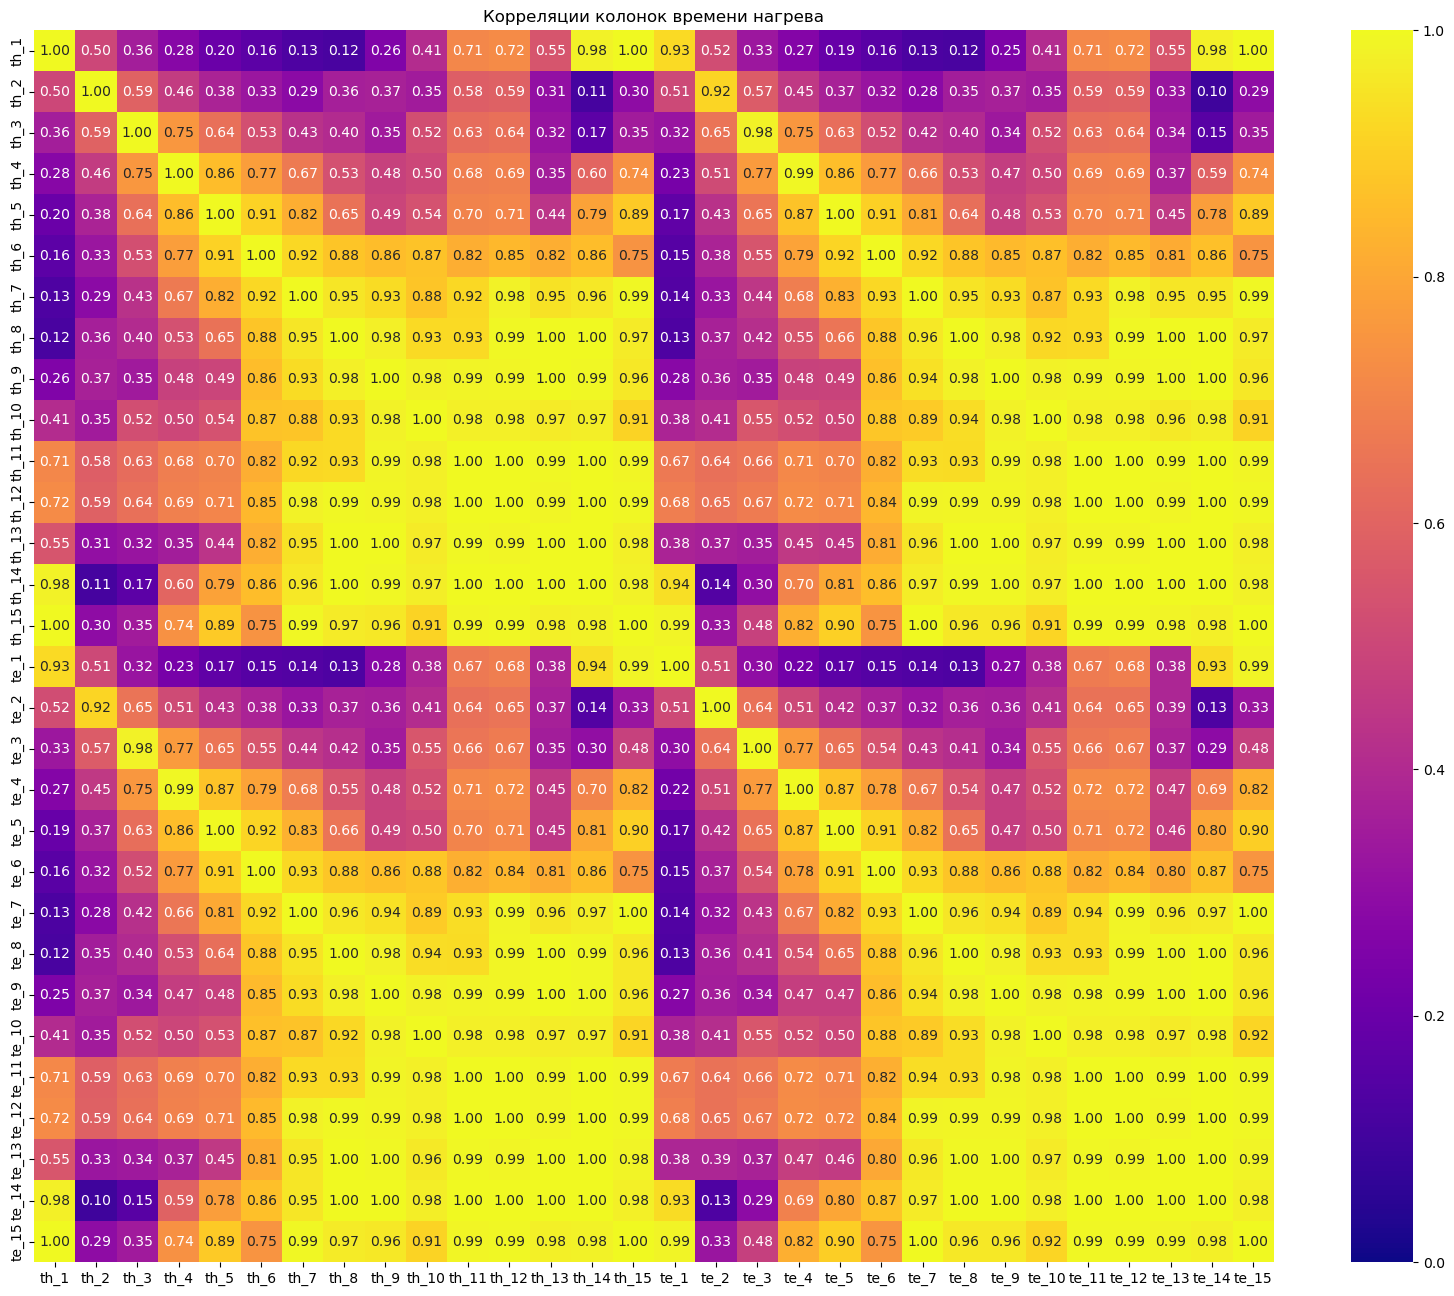

In [35]:
show_heat_map( df[begin_heat_cols+end_heat_cols],"Корреляции колонок времени нагрева");

Во-первых, преобразуем окончания плавок в продолжительность и создадим колонки нового типа

In [36]:
df_dur = pd.DataFrame({ f"td_{i}":  df[f"te_{i}"] -df[f"th_{i}"] for i in range(1,16)  })
df = pd.concat([df.drop(end_heat_cols,axis=1),df_dur],axis=1)

и посмотрим результат

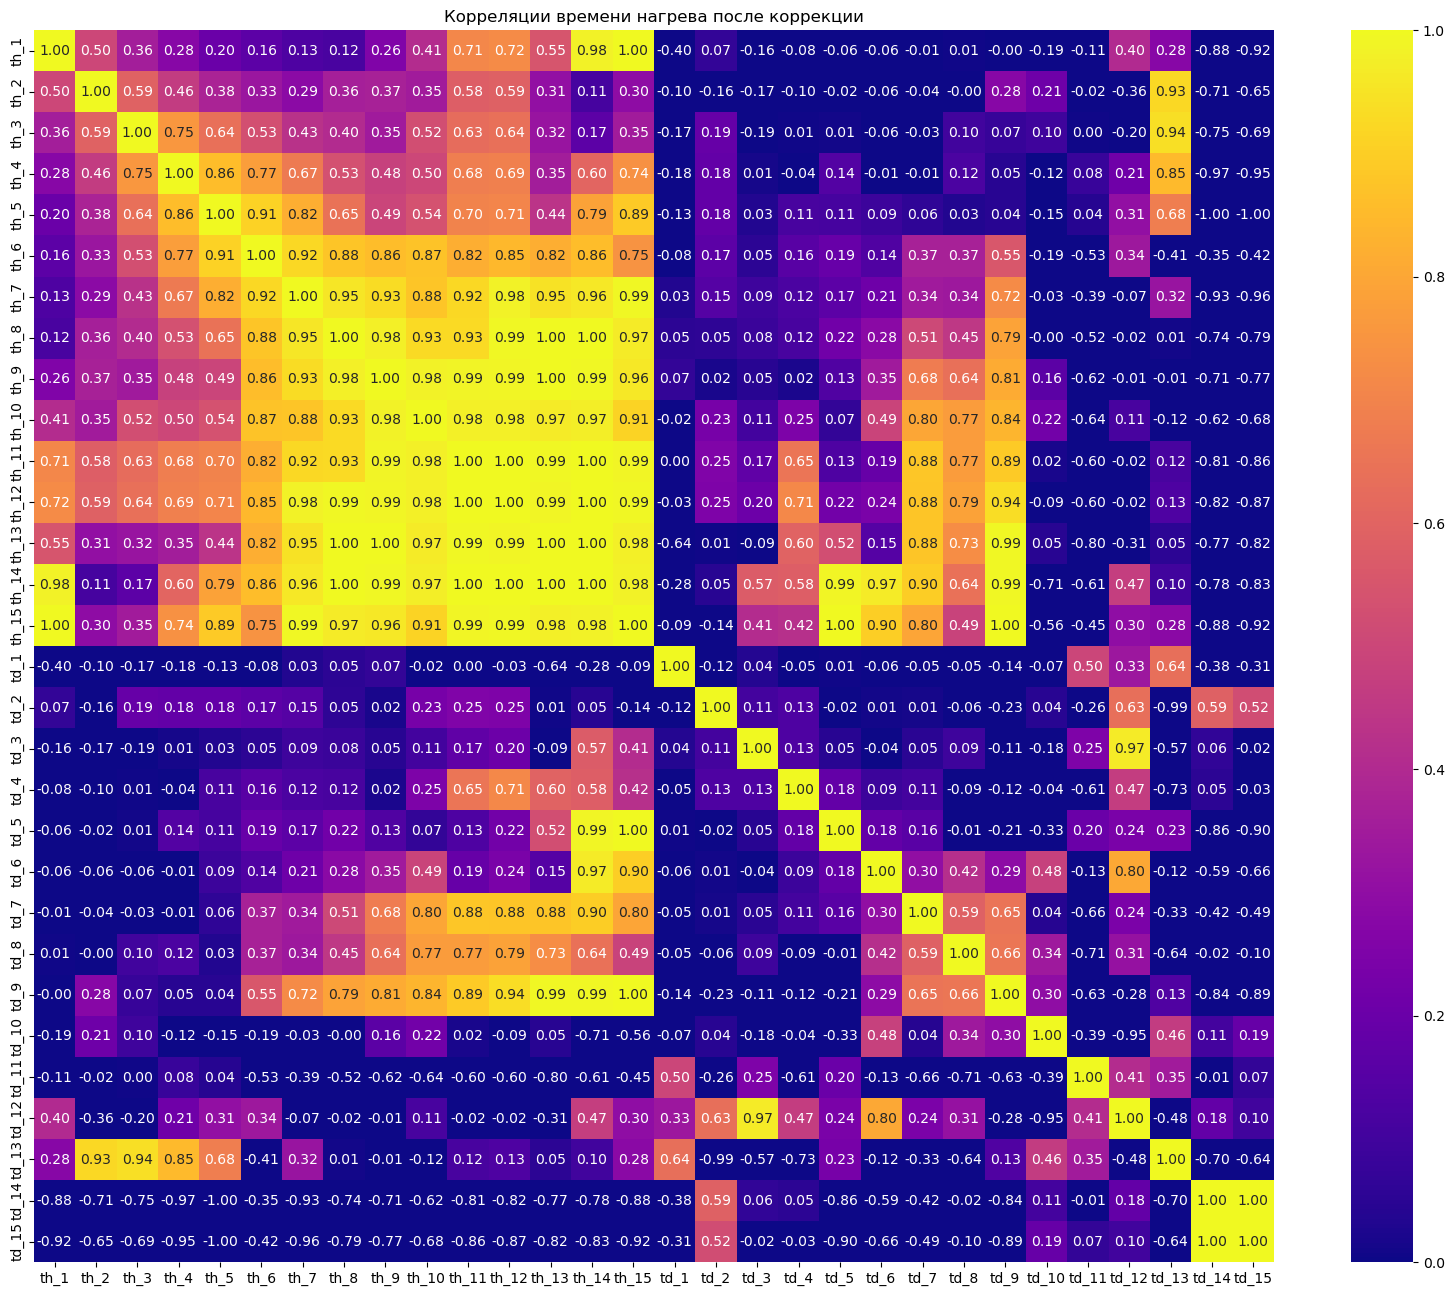

In [37]:
dur_heat_cols = [c for c in df_dur.columns]
dur_heat_cols,begin_heat_cols
heat_cols = begin_heat_cols + dur_heat_cols
show_heat_map( df[heat_cols],'Корреляции времени нагрева после коррекции' )

Момента начала последних плавок все равно сильно коррелируют между собой, также как и продолжительности   
Видимо тут уже не нужно искать преобразования и их нужно просто выкинуть 

In [38]:
df = df.drop([f"th_{i}" for i in range(7,16) ],axis=1)
df = df.drop([f"td_{i}" for i in range(12,16) ],axis=1)

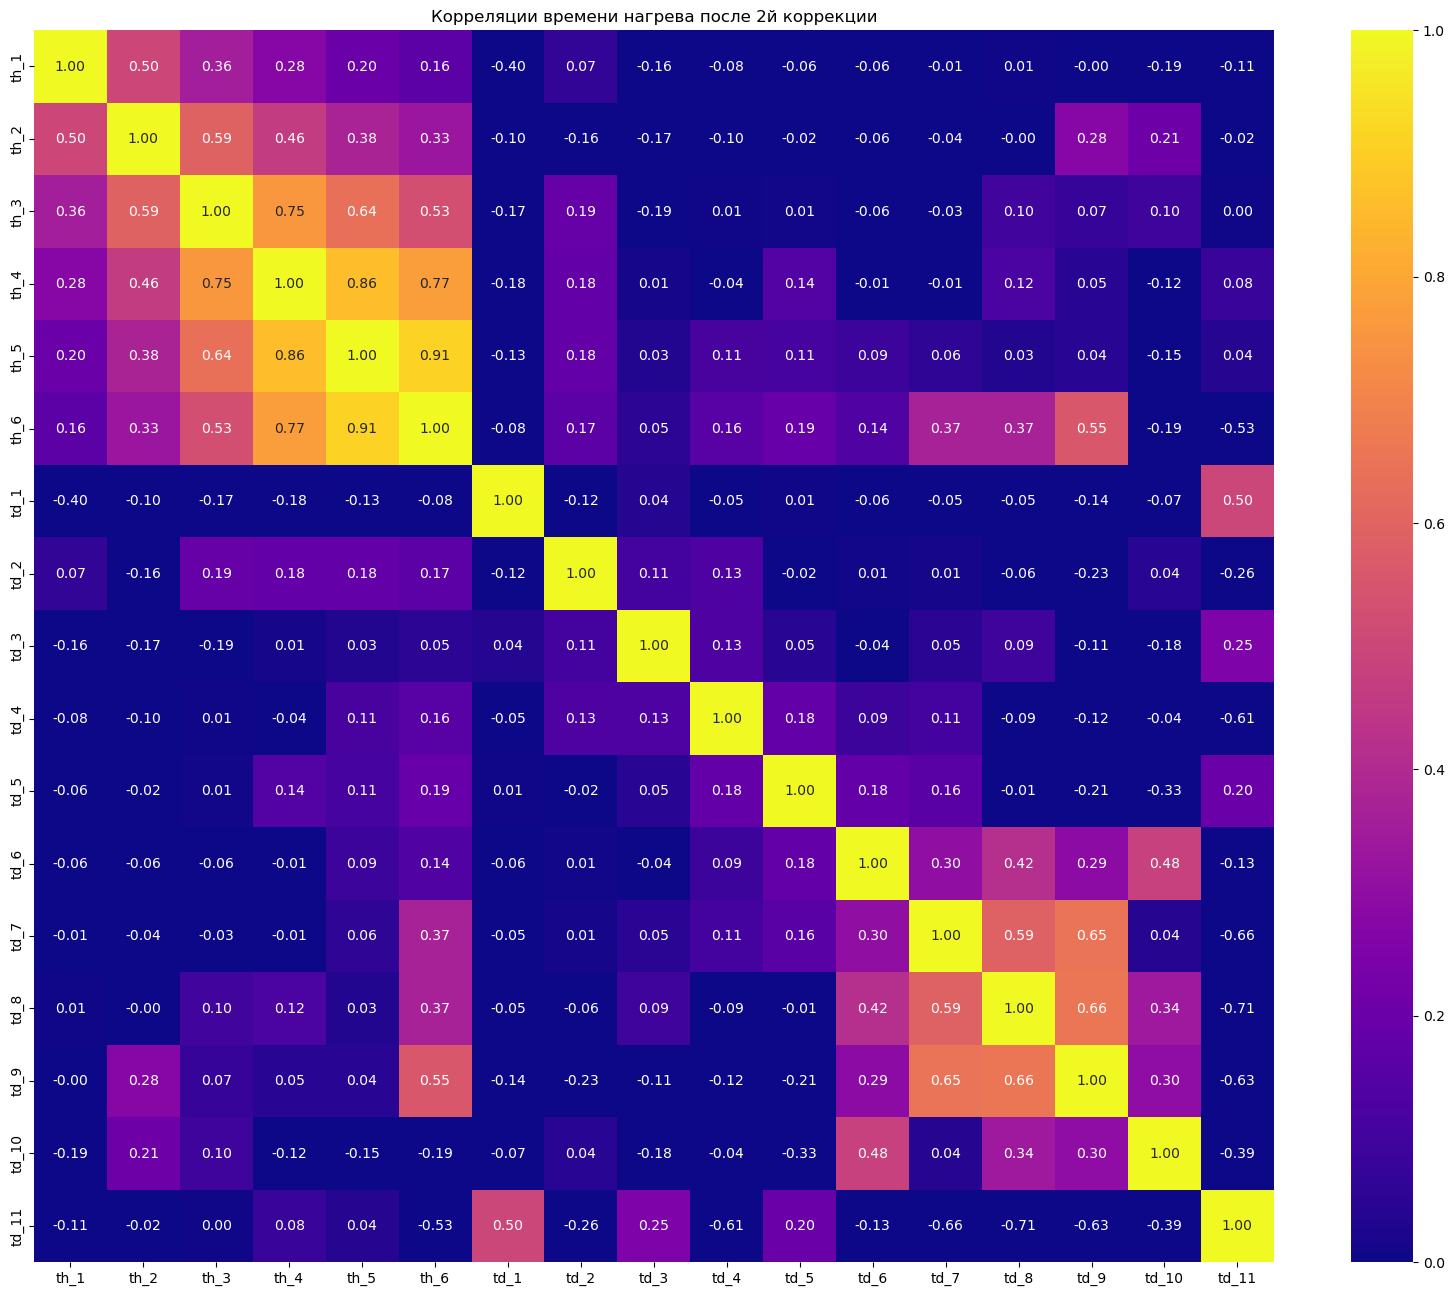

In [39]:
heat_cols = [c for c in df.columns if c[:2] in ['th','td']  ] 
show_heat_map( df[heat_cols],'Корреляции времени нагрева после 2й коррекции' )

<s>Между параметрами добавок есть довольно сильные корреляции до 0.8   
Но так как это редко используемые параметры и они влияют в основном на сходимость , а не на метрику, я 
</s>    

#### Корреляции мощности

Для мощности также есть сильные корреляции между активной и реактивной мощностью   
Здесь во-первых нужно преобразование, которое было в трансформере  - рассчитать полную мощность и какой-нибудь дополнительный параметр, например разность 

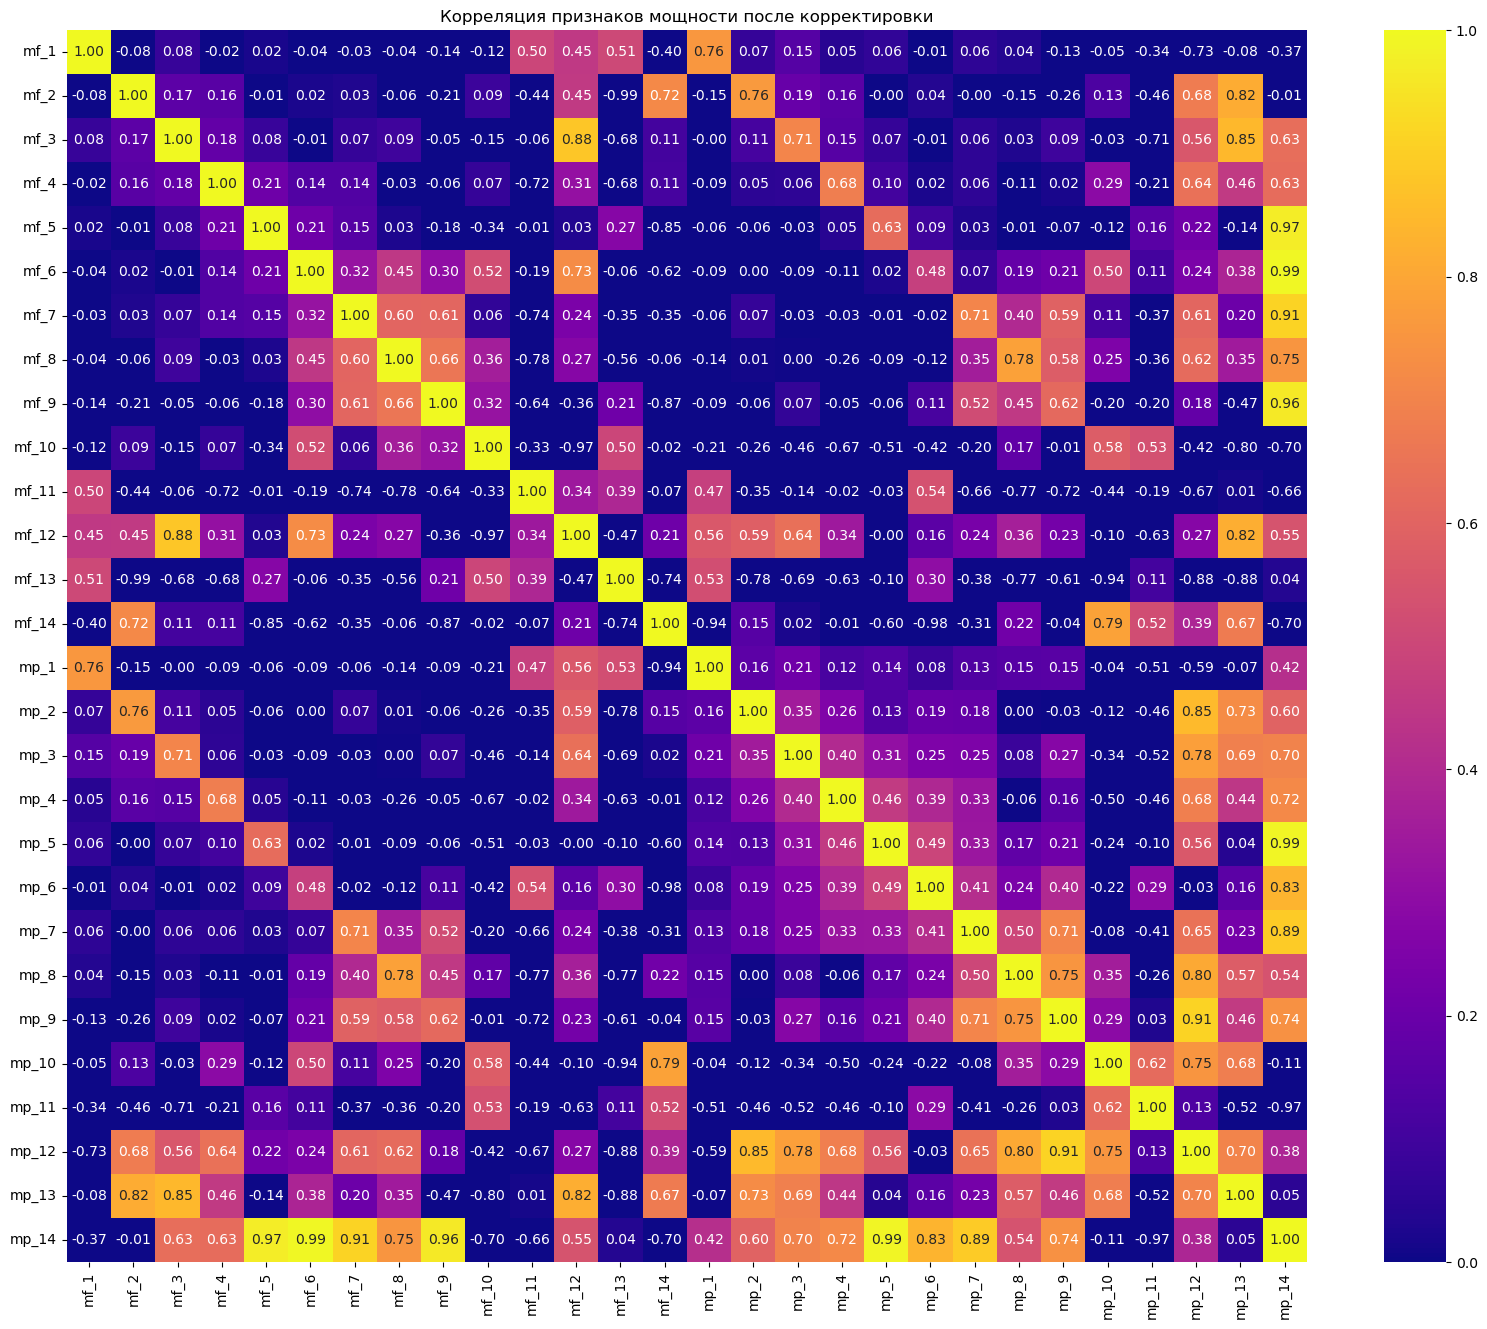

In [40]:
df_full_power = pd.DataFrame({ \
    f"mf_{i}":  np.sqrt( np.power( df[f"ma_{i}"],2) +np.power(df[f"mr_{i}"],2) ) \
                for i in range(1,15)  })
df_diff_power = pd.DataFrame({ f"mp_{i}":df[f"ma_{i}"]-df[f"mr_{i}"] for i in range(1,15)})   
df = pd.concat([df.drop(active_cols+reactive_cols,axis=1),df_full_power,df_diff_power ],axis=1)
power_cols = [ c for c in df.columns if c[:2] in ['mf','mp'] ]
show_heat_map(df[power_cols],'Корреляция признаков мощности после корректировки')    

Посмотрим, есть ли  корреляции для всех признаков плавок включая и мощности и временные параметры

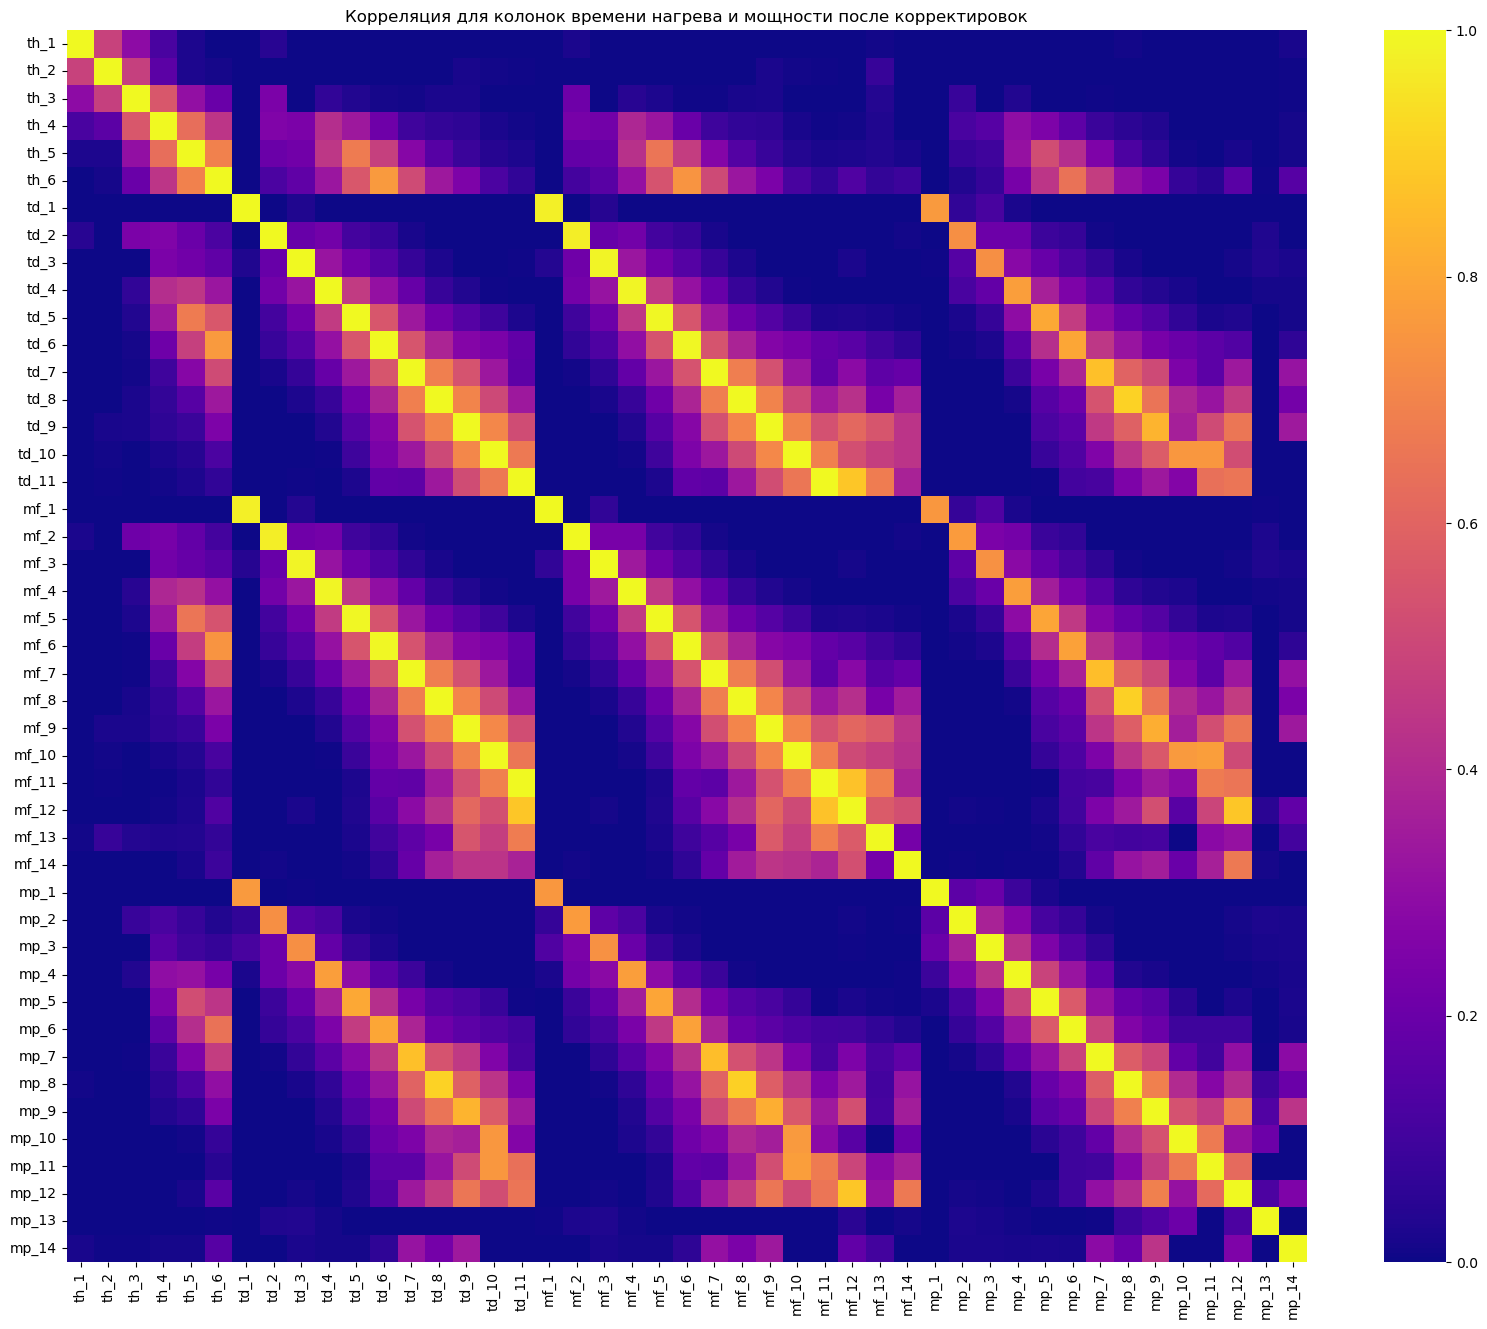

In [41]:
show_heat_map(df[heat_cols+power_cols].fillna(0),
              "Корреляция для колонок времени нагрева и мощности после корректировок",annotations=False)

Неожиданно обнаружены сильные корреляции между длительностяи нагрева(td) и полными  мощностями 
От каких-то параметров нужно избавиться, видимо можно удалить все длятильености нагрева ,   
которые в топе списка корреляций

In [42]:
top_corr(df[heat_cols+power_cols],30) 

      variable     value
td_9      mf_9  0.996970
td_10    mf_10  0.995518
td_8      mf_8  0.995233
td_11    mf_11  0.994858
mp_14     mf_6  0.993920
td_7      mf_7  0.992656
mp_5     mp_14  0.990452
td_5      mf_5  0.987005
td_6      mf_6  0.985835
td_4      mf_4  0.985307
td_6     mp_14  0.984897
td_3      mf_3  0.981350
td_9     mp_14  0.980759
td_1      mf_1  0.976629
td_5     mp_14  0.973840
td_2      mf_2  0.973439
mp_14     mf_5  0.971602
td_3     mf_12  0.963451
th_1     mp_14  0.962778
mp_14     mf_9  0.961016
th_3     mf_13  0.945827
th_2     mf_13  0.931241
td_7     mp_14  0.930660
mp_14     mf_7  0.912022
mp_9     mp_12  0.910622
td_2     mp_13  0.910272
th_6      th_5  0.908635
th_6     mp_14  0.899120
mp_7     mp_14  0.892934
mf_3     mf_12  0.879211


In [43]:
df = df.drop([ c for c in df.columns if c[:2]=='td' ],axis=1)

#### Прочие корреляции

Вообще говоря, корреляцию нужно считать с запоненными пустыми значениями, которые я предполагаю заполнить нулями  
Но здесь он и еще не запонены, так как я хочу на всякий случай отличать истинные нули от сгенериррованных  
Поэтому при построении тепловой карты я предварительно заполняю фрейм нулями

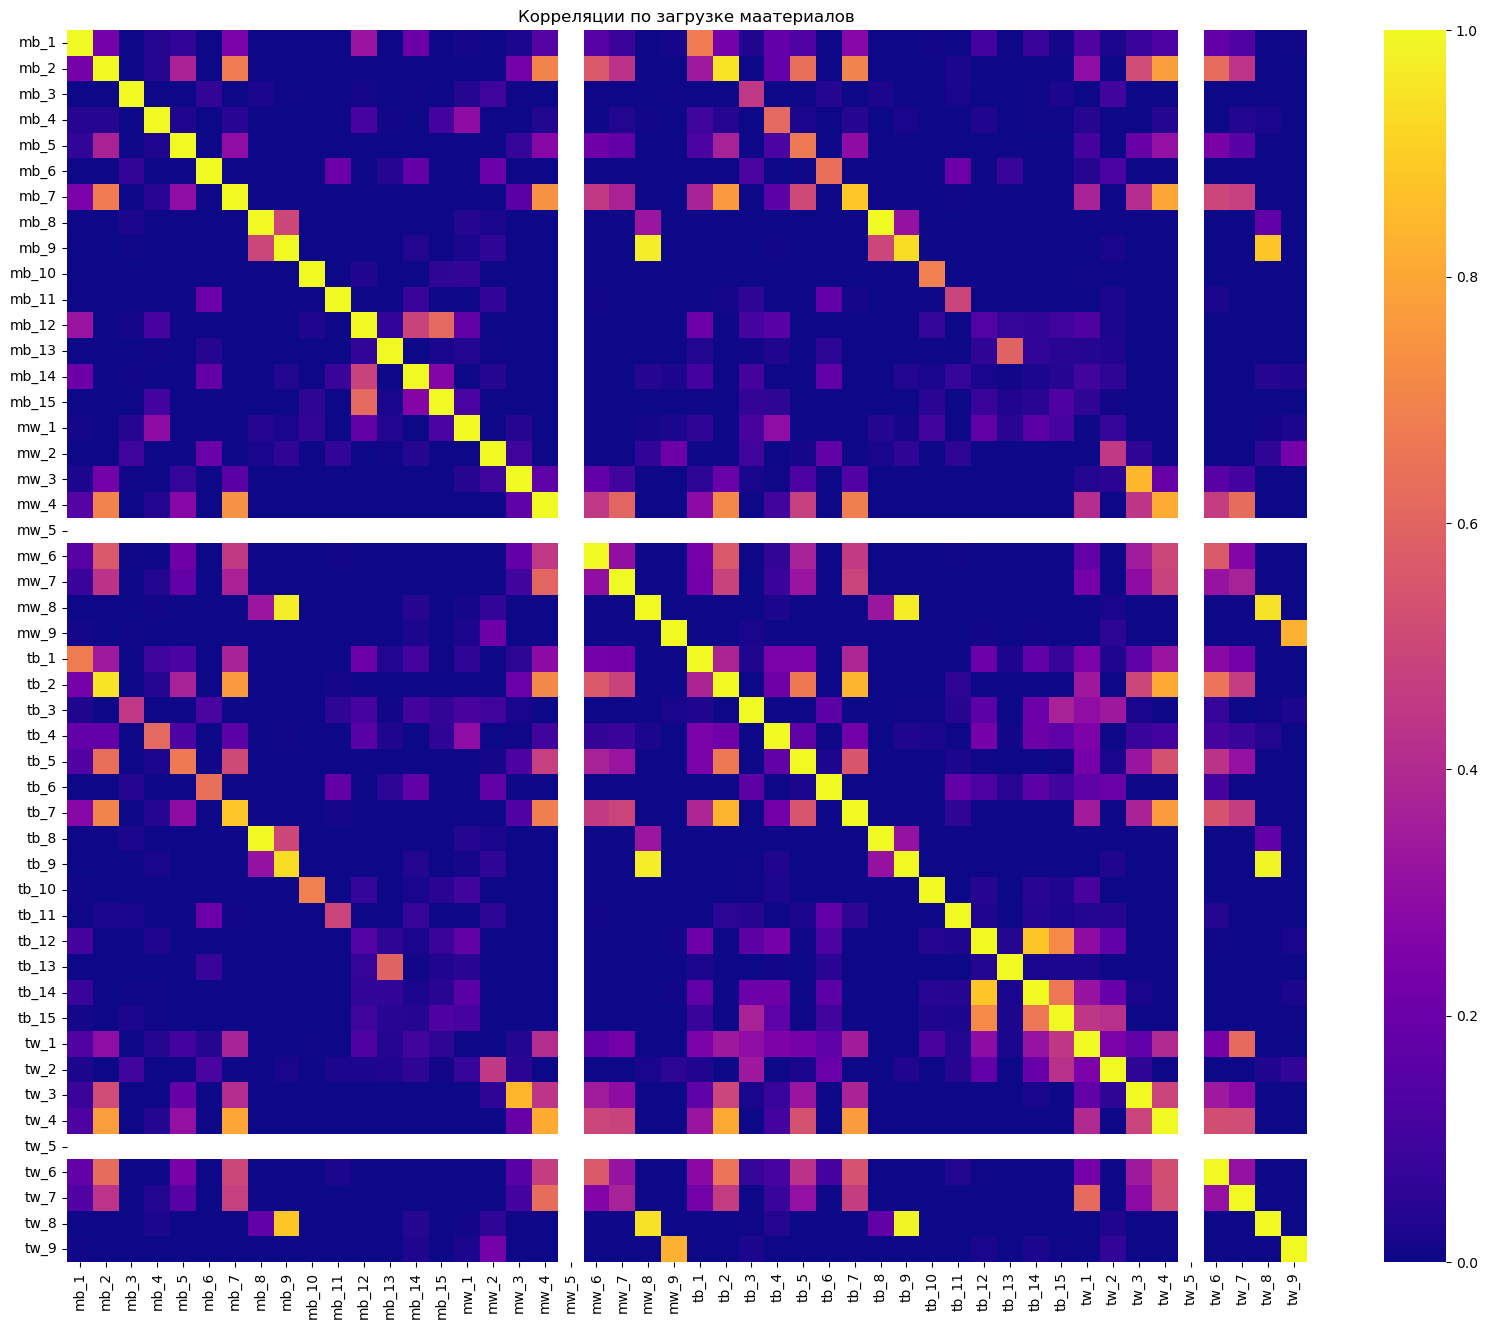

In [44]:
show_heat_map( df[bulk_cols+wire_cols+bulk_time_cols+wire_time_cols].fillna(0),
              'Корреляции по загрузке маатериалов',annotations=False )

обнаружен небольшой кластер корреляций bulk 8,9 - wire 8

In [45]:
top_corr( df[bulk_cols+wire_cols+bulk_time_cols+wire_time_cols].fillna(0),5)

     variable     value
tb_8     mb_8  1.000000
tw_8     tb_9  0.989065
mw_8     mb_9  0.973814
tb_9     mw_8  0.969964
tb_2     mb_2  0.952451


Проверка показывает, что тут всего 12 значений у каждого признака, и они расположены в тех же 12 строчках  
Видимо можно оставить тольок один признак mw_8
Так же нужно удалить один из пары bulk 2/ time bulks 2 и пустые признаки mw_5 tw_5

In [46]:
cols_89 = ['tb_8','tw_8','tb_9','mw_8','mb_9']
print( df[cols_89].count() )
print( df[df[cols_89].notna().any(axis=1) ][cols_89] )
df = df.drop([c for c in cols_89 if not c == 'mw_8'],axis=1)
df = df.drop(['tb_2'],axis=1)
df = df.drop(['mw_5','tw_5'],axis=1)

tb_8     1
tw_8    12
tb_9    12
mw_8    12
mb_9    12
dtype: int64
        tb_8    tw_8    tb_9        mw_8   mb_9
239      NaN   440.0   508.0   46.094879   68.0
240      NaN   429.0   511.0   46.187439   65.0
241      NaN  1158.0  1226.0   46.094879   71.0
242      NaN   372.0   455.0   46.279999   66.0
243      NaN   400.0   477.0   46.187439   70.0
244      NaN   924.0   997.0   46.187439   66.0
245      NaN   923.0   998.0   45.354401   70.0
246      NaN  1043.0  1109.0   45.076721   66.0
247      NaN  1067.0  1108.0   45.076721   65.0
1626  1428.0   719.0  1343.0   68.494405  147.0
1805     NaN  2164.0  2127.0  102.762401  111.0
1806     NaN  2253.0  2247.0   95.244248  108.0


#### Порядок операций

Обновим макросы для наборов колонок

In [47]:
magni_cols = [c for c in df.columns if c[0]=='m']
time_cols = [c for c in df.columns if c[0]=='t']

tier1_cols = [ c for c in magni_cols+time_cols if df[c].notna().sum()>=1_000 ]
magni1_cols = [ c for c in magni_cols if c in tier1_cols ]
time1_cols = [ c for c in time_cols if c in tier1_cols ]

tier2_cols = [ c for c in magni_cols+time_cols if 100 <= df[c].notna().sum()<1_000 ]
magni2_cols = [ c for c in magni_cols if c in tier2_cols ]
time2_cols = [ c for c in time_cols if c in tier2_cols ]

tier3_cols = [ c for c in magni_cols+time_cols if 1 <= df[c].notna().sum()<100 ]
begin_heat_cols = [ c for c in time_cols if c[1]=='h' ]
end_heat_cols = [ c for c in time_cols if c[1]=='e' ]
bulk_time_cols = [c for c in df.columns if c[:2]=='tb']
wire_time_cols = [c for c in df.columns if c[:2]=='tw']
bulk_cols = [c for c in df.columns if c[:2]=='mb']
wire_cols = [c for c in df.columns if c[:2]=='mw']

int_cols = [c for c in df.columns if c[:3]=='num']

null_cols = [ c for c in magni_cols+time_cols if  df[c].notna().sum() ==0 ]
null_cols


[]

И выведем heatmap для финальной конфигурации модели 

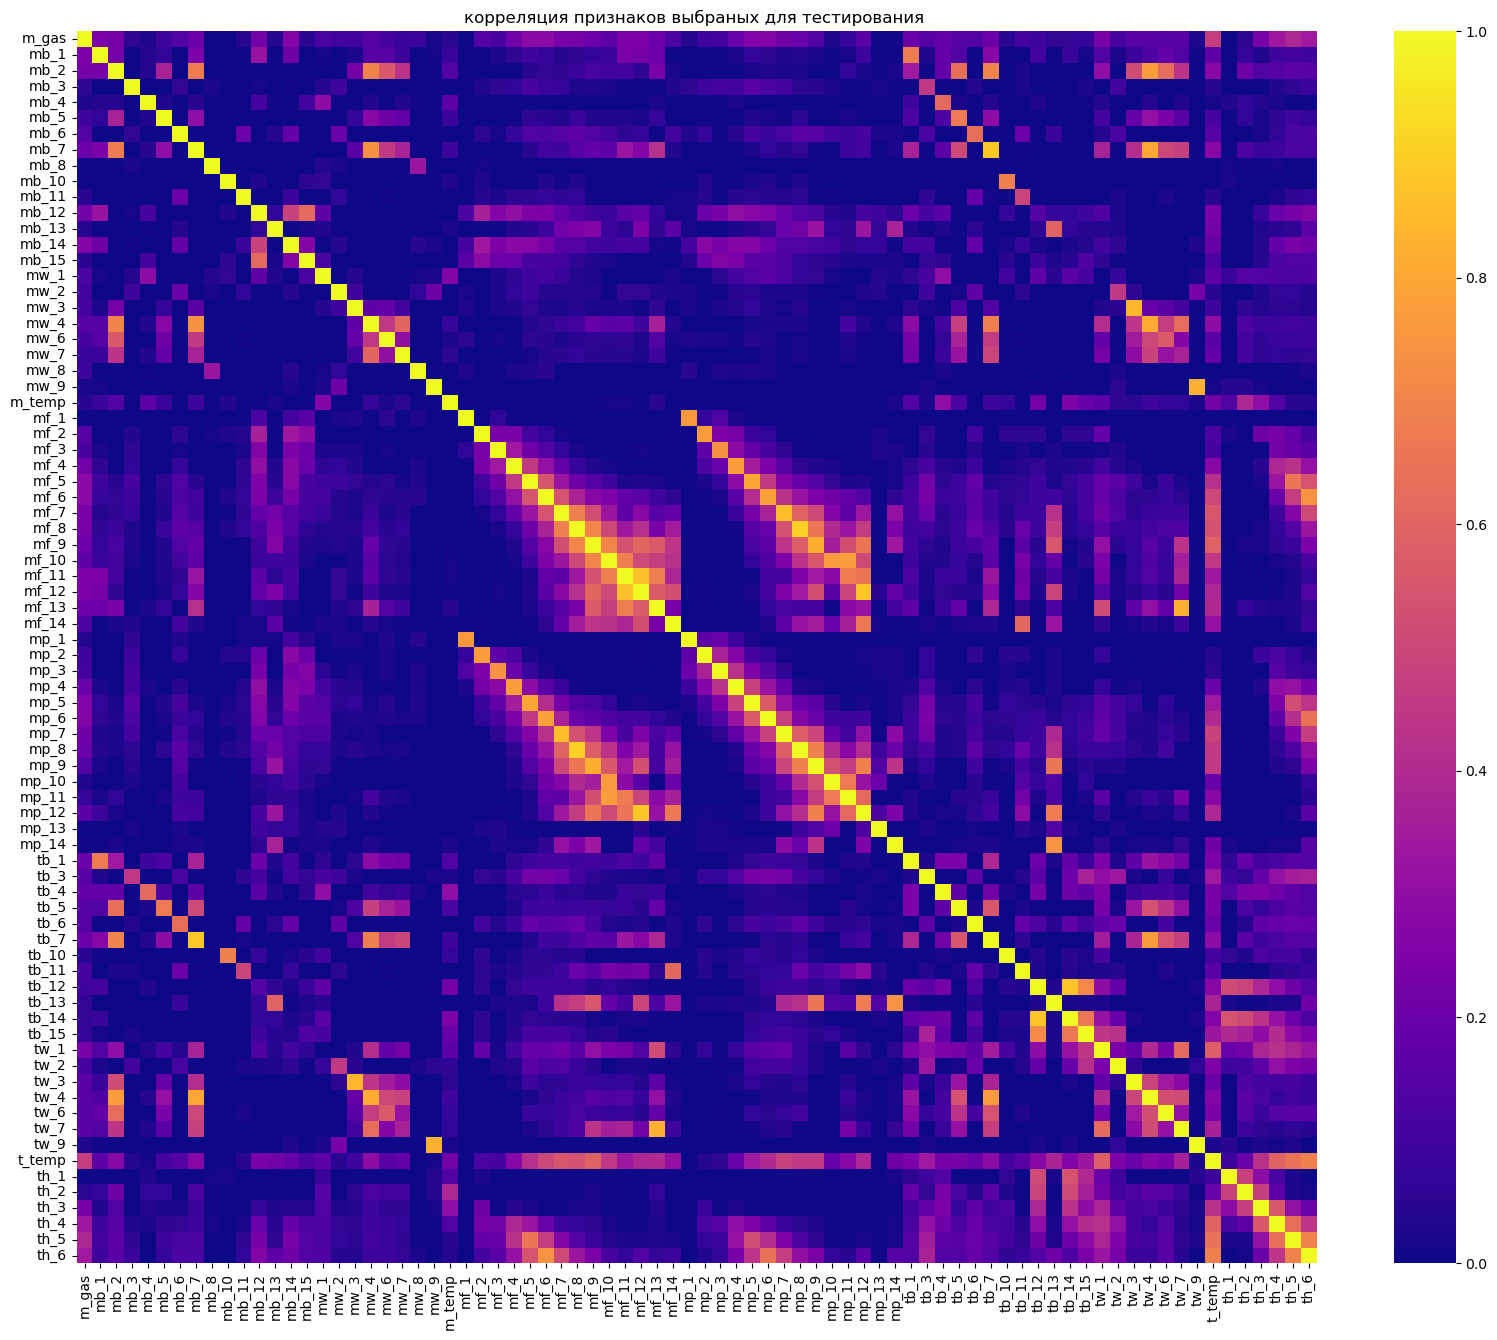

In [48]:
show_heat_map(df[magni_cols+time_cols].fillna(0),'корреляция признаков выбраных для тестирования ',annotations=False)

In [49]:
top_corr(df[magni_cols+time_cols].fillna(0))

      variable     value
mp_8      mf_8  0.904303
tb_7      mb_7  0.883725
mp_12    mf_12  0.879453
tb_14    tb_12  0.876160
mf_12    mf_11  0.869494
mp_7      mf_7  0.859478
tw_3      mw_3  0.843222
tw_7     mf_13  0.826007
tw_9      mw_9  0.824272
mp_9      mf_9  0.819433


Все же осталась пара признаков чуть за границей 0.90 но мне кажется можно так оставить (не хочется дальше ухудшать читаемость блокнота )

## Моделирование

#### Заполнение пустых значений

Пропуски операций естественно заполнить нулями

In [50]:
df= df.fillna(0)

#### Разбиение данных

Зафиксируем 
* целевой признак - <b>y_temp</b> 
* обучающие признаки - все колонки величин, времени и количества плавок (с префиксами <b> m- ,t- , num- </b>)   

Не используются колонки key и begin_time

In [51]:
y = 'y_temp'
X = (magni_cols + time_cols+ int_cols)
print('Обучающие признаки',sorted(X) )

Обучающие признаки ['m_gas', 'm_temp', 'mb_1', 'mb_10', 'mb_11', 'mb_12', 'mb_13', 'mb_14', 'mb_15', 'mb_2', 'mb_3', 'mb_4', 'mb_5', 'mb_6', 'mb_7', 'mb_8', 'mf_1', 'mf_10', 'mf_11', 'mf_12', 'mf_13', 'mf_14', 'mf_2', 'mf_3', 'mf_4', 'mf_5', 'mf_6', 'mf_7', 'mf_8', 'mf_9', 'mp_1', 'mp_10', 'mp_11', 'mp_12', 'mp_13', 'mp_14', 'mp_2', 'mp_3', 'mp_4', 'mp_5', 'mp_6', 'mp_7', 'mp_8', 'mp_9', 'mw_1', 'mw_2', 'mw_3', 'mw_4', 'mw_6', 'mw_7', 'mw_8', 'mw_9', 'num_melts', 't_temp', 'tb_1', 'tb_10', 'tb_11', 'tb_12', 'tb_13', 'tb_14', 'tb_15', 'tb_3', 'tb_4', 'tb_5', 'tb_6', 'tb_7', 'th_1', 'th_2', 'th_3', 'th_4', 'th_5', 'th_6', 'tw_1', 'tw_2', 'tw_3', 'tw_4', 'tw_6', 'tw_7', 'tw_9']


Разбиваем данные на тренировочный и тестовый наборы с параметрами,  указанными в требованиях к проекту. <br>
Выделение валидационных наборов производится в процедурах кроссвалидации 

In [52]:
df_tr, df_te = train_test_split(df, test_size=.25, shuffle=True, random_state=RANDOM_STATE)

### Обучение моделей

 В заданни проекта есть рекомендации по созданию дополнительных признаков,  
 чтобы проверить насколько они полезны, я написал небольшой трансформер, который умеет выполнять две задачи:
 - объединять активную и реактивную мощность полную и выделять косинус угла между акивной и реактивной
 - объединять все павки в интегральную с общими мощностями и средними временами начала и конца (желательно среднее время начала и средняя продолжительность, но это линейные операции и на модели влиять не должны)
 - и кроме того может ничего не менять  ( dummy_transformer)
 Как я понимаю, после трансформации оригинальные признаки нужно удалять, чтобы не получить корреляцию

In [53]:
def dummy_transformer(X):
    Xc = X.copy()
    return Xc

def full_power_transformer(X):
    func0 = lambda a,b: np.sqrt(np.power( a,2) + np.power(b,2) )
    func1 = lambda a,b: np.divide(a, func0(a,b), out=np.zeros_like(a), where=b!=0)
    Xc = X.copy()
    for i in range(1,15): 
        Xc[f"ma_{i}"] = func0(X[f"ma_{i}"],X[f"mr_{i}"]) # * (X[f"te_{i}"]-X[f"th_{i}"]) 
        Xc[f"mr_{i}"] = func1(X[f"ma_{i}"],X[f"mr_{i}"])        
    return Xc

def agg_transformer(X):
    Xc = X.copy()
    act_cols = [c for c in X.columns if c[:2]=='ma' ]
    react_cols = [c for c in X.columns if c[:2]=='mr' ]
    begin_cols = [c for c in X.columns if c[:2]=='th' ]
    end_cols = [c for c in X.columns if c[:2]=='te' ]    
    copy_cols = [c for c in X.columns if c not in act_cols + react_cols + begin_cols + end_cols  ]
    agg  ={}
    avg = lambda subframe: (subframe.sum(axis=1)/(subframe>0).astype(int).sum(axis=1)).replace((np.inf, -np.inf),(0,0))
    agg['th'] = avg(X[begin_cols])
    agg['te'] = avg(X[end_cols])
    agg['ma'] = X[act_cols].sum(axis=1)
    agg['mr'] = X[react_cols].sum(axis=1)

    Xc =  pd.concat([ Xc[copy_cols], pd.DataFrame(agg)] , axis=1)

    return(Xc)

class PowerTransformer(BaseEstimator, TransformerMixin):
    transformers = {
        'dummy': dummy_transformer,
        'full_power': full_power_transformer,
        'agg' : agg_transformer 
    }
                     
    def __init__(self,tf_name = 'dummy'):
        super().__init__()
        self.tf_name = tf_name
        
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        try:
            func= self.transformers[self.tf_name]
        except Exception as e:
            print('Failed to find transformer by name:',e)
        return func(X)

Проверим последовательно различные модели

### Dummy regressor

In [54]:
%%time

power_tf = PowerTransformer()
scaler = StandardScaler()
model= DummyRegressor()
scoring=['neg_mean_absolute_error','r2']
refit = scoring[0]

params_grid = {
    'mod__strategy': ['mean','median']
}

pipe = Pipeline( [['pow', power_tf],['sca',scaler],['mod',model]])
lin_gcv = GridSearchCV(pipe,params_grid,cv =4,scoring=scoring,refit=refit)
lin_res = lin_gcv.fit(df_tr[X],df_tr[y])
lin_gcv.best_score_,lin_gcv.best_params_

CPU times: user 280 ms, sys: 24 µs, total: 280 ms
Wall time: 278 ms


(-7.936357214324197, {'mod__strategy': 'median'})

Базовая оценка : при предсказании по медиане <b>MAE= 7.93</b>

### Линейная регрессия

In [55]:
%%time
power_tf = PowerTransformer()
scaler = StandardScaler()
model= SGDRegressor(max_iter =100_000)
scoring=['neg_mean_absolute_error','r2']
refit = scoring[0]

params_grid = {
    'pow__tf_name': ['dummy'],
    'mod__penalty': ['l2','l1'],
    'mod__eta0':[.01,.003,.001,3e-4,1e-4]
}

pipe = Pipeline( [['pow', power_tf],['sca',scaler],['mod',model]])
lin_gcv = GridSearchCV(pipe,params_grid,cv =4,scoring=scoring,refit=refit)
lin_res = lin_gcv.fit(df_tr[X],df_tr[y])
lin_gcv.best_score_,lin_gcv.best_params_

CPU times: user 6.52 s, sys: 393 µs, total: 6.52 s
Wall time: 6.52 s


(-5.513992097784198,
 {'mod__eta0': 0.001, 'mod__penalty': 'l2', 'pow__tf_name': 'dummy'})

In [56]:
lin_res = lin_gcv.cv_results_
lin_res

{'mean_fit_time': array([0.02192277, 0.00813639, 0.01538509, 0.03041112, 0.0767892 ,
        0.13724279, 0.14541566, 0.21418941, 0.34203863, 0.56746703]),
 'std_fit_time': array([0.00834903, 0.00089358, 0.00765743, 0.02981003, 0.00976   ,
        0.03047184, 0.01025141, 0.01646831, 0.01120195, 0.0111919 ]),
 'mean_score_time': array([0.00686532, 0.00321114, 0.00446451, 0.00717074, 0.00372785,
        0.00346297, 0.00320715, 0.00270468, 0.0031175 , 0.00242698]),
 'std_score_time': array([5.08988420e-03, 1.12377678e-03, 8.23697486e-04, 1.06935492e-03,
        2.03683945e-03, 1.37239387e-03, 9.22610165e-04, 5.66703018e-04,
        9.42616797e-04, 5.87232511e-05]),
 'param_mod__eta0': masked_array(data=[0.01, 0.01, 0.003, 0.003, 0.001, 0.001, 0.0003, 0.0003,
                    0.0001, 0.0001],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_mod__penalty': masked_array

In [57]:
lin_pars = ParsedResult(lin_res,metric_name='neg_mean_absolute_error')
idx = pd.IndexSlice
lin_sel = lin_pars.select('mod__eta0')
lin_sel

mean_test_neg_mean_absolute_error              
mod__penalty                                l1            l2
mod__eta0                                                   
0.0001                           -5.592748e+00 -5.589709e+00
0.0003                           -5.576131e+00 -5.556376e+00
0.001                            -5.519068e+00 -5.513992e+00
0.003                            -2.075956e+03 -1.057712e+03
0.01                             -4.240963e+09 -3.533331e+09

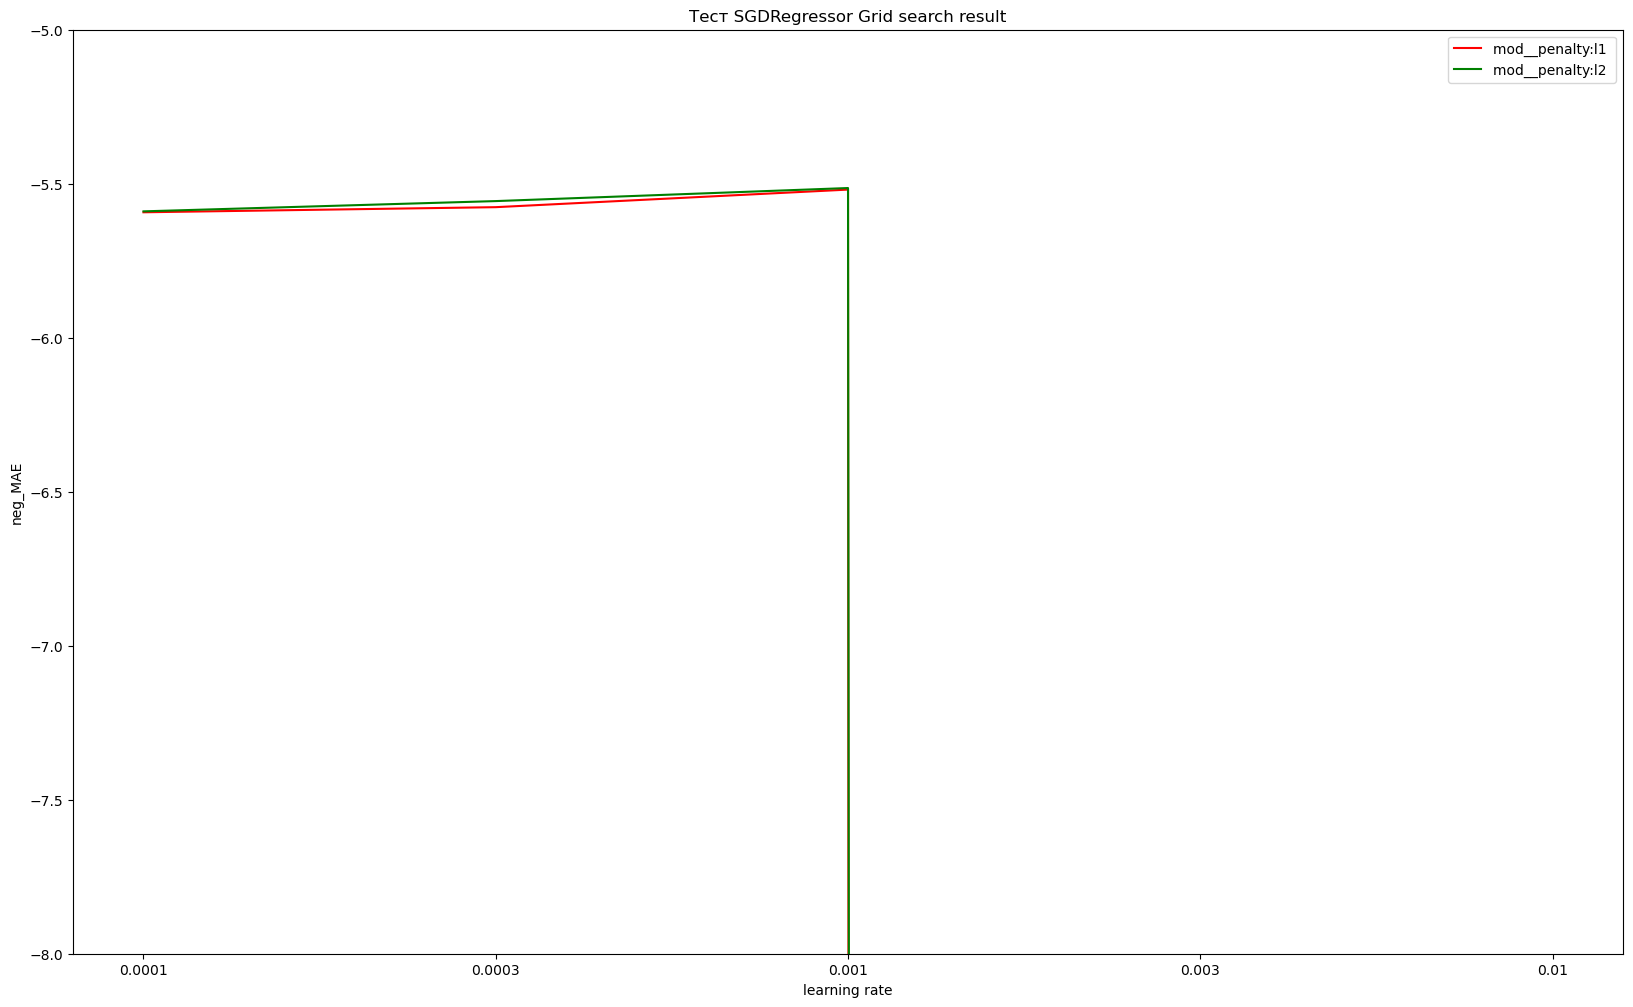

In [58]:
ResultPlotter(lin_sel,{'title':'SGDRegressor Grid search result','metric':'neg_MAE'}).plot()
plt.ylim(-8,-5);
plt.show()

Модель SGDRegressor показывает работает быстро , показывает хороший результат при eta= 0.0001 - 0.001  
Метрика резко падает при приближении скорости eta к дефолтным  0.01 .  
Лучшая метрика на кроссвалидации <b>MAE = 5.52</b>  
это намного лучше тривиального предсказания, где среднее отклоненеие было 7.93

### Light Gradient Boosting

In [59]:
%%time
power_tf = PowerTransformer()
scaler = StandardScaler()
model = lgb.LGBMRegressor(verbose = -1,random_state=RANDOM_STATE)
scoring=['neg_mean_absolute_error','r2']
refit = scoring[0]

params_grid = {
    'pow__tf_name': ['dummy'],
    'mod__learning_rate': [.3,.1,.03,.01,.003],
    'mod__n_estimators':[1024],
    'mod__boosting' :['gbdt','dart'],
    'mod__max_depth':  [32],#[32,128,1024],
    'mod__num_leaves': [512]       
}

pipe = Pipeline( [['pow', power_tf],['sca',scaler],['mod',model]])
lgb_gcv = GridSearchCV(pipe,params_grid,cv =4,scoring=scoring,refit=refit)
lgb_res = lgb_gcv.fit(df_tr[X],df_tr[y])
lgb_gcv.best_score_,lgb_gcv.best_params_

CPU times: user 2min 50s, sys: 81.4 ms, total: 2min 50s
Wall time: 2min 50s


(-5.67519785333028,
 {'mod__boosting': 'gbdt',
  'mod__learning_rate': 0.01,
  'mod__max_depth': 32,
  'mod__n_estimators': 1024,
  'mod__num_leaves': 512,
  'pow__tf_name': 'dummy'})

In [60]:
lgb_res = lgb_gcv.cv_results_
lgb_res

{'mean_fit_time': array([2.73070264, 2.99972278, 2.64140272, 2.24763727, 2.19088715,
        5.99689782, 5.62485403, 5.42118686, 5.88964516, 5.64365071]),
 'std_fit_time': array([0.38193483, 0.31505927, 0.25054645, 0.02384541, 0.02131541,
        0.35668908, 0.15731958, 0.097839  , 0.49492439, 0.70661573]),
 'mean_score_time': array([0.06431556, 0.06902206, 0.05795878, 0.04907984, 0.03662211,
        0.0474261 , 0.04374266, 0.04193836, 0.03734326, 0.0335027 ]),
 'std_score_time': array([0.00378924, 0.00805156, 0.00452564, 0.00179711, 0.00068952,
        0.00271963, 0.00213718, 0.00405575, 0.00482131, 0.00752118]),
 'param_mod__boosting': masked_array(data=['gbdt', 'gbdt', 'gbdt', 'gbdt', 'gbdt', 'dart', 'dart',
                    'dart', 'dart', 'dart'],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_mod__learning_rate': masked_array(data=[0.3, 0.1, 0.03, 0.01, 0

In [61]:
lgb_pars = ParsedResult(lgb_res,metric_name='neg_mean_absolute_error')
idx = pd.IndexSlice
#print( lgb_pars.select('mod__learning_rate').loc[:,idx[:,:,['dart']]] )
lgb_sel = lgb_pars.select('mod__learning_rate')#.loc[:,idx[:,:,'gbdt']] 
lgb_sel

mean_test_neg_mean_absolute_error          
mod__boosting                                   dart      gbdt
mod__learning_rate                                            
0.003                                    -708.606997 -5.927341
0.01                                     -282.261772 -5.675198
0.03                                      -94.949977 -5.677430
0.1                                       -23.137065 -5.776415
0.3                                        -6.594699 -6.000088

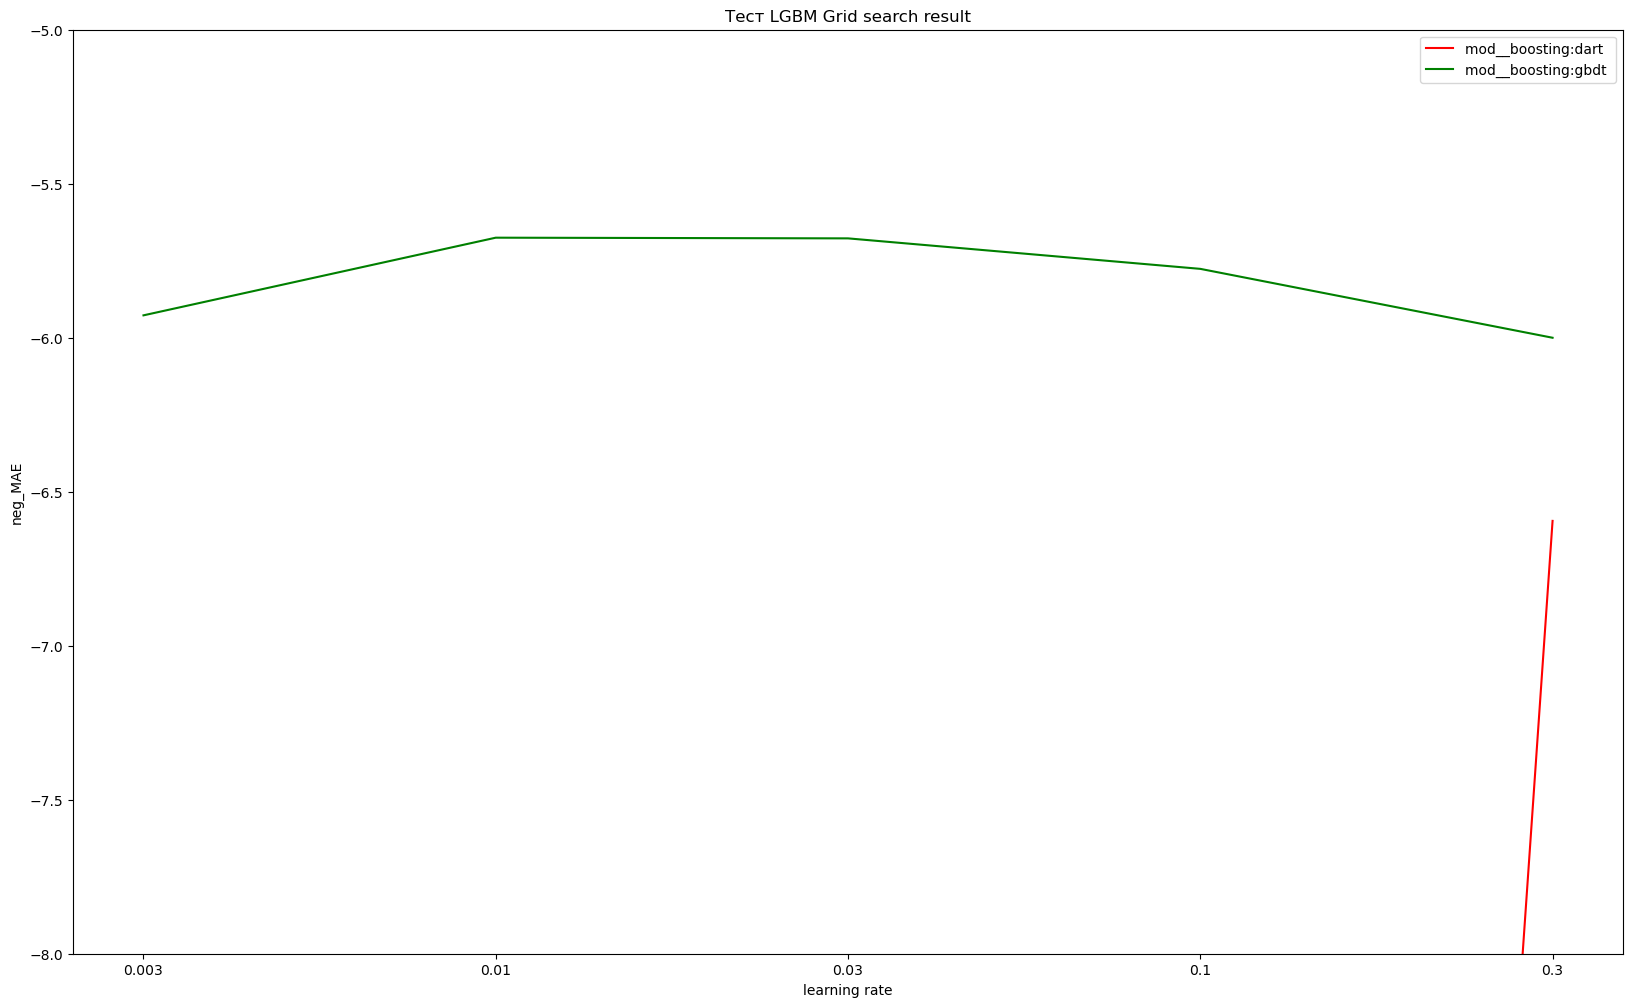

In [62]:
ResultPlotter(lgb_sel,{'title':'LGBM Grid search result','metric':'neg_MAE'}).plot()
plt.ylim(-8,-5);
plt.show()

Результат довольно нестабилен, особенно при бустинге dart.  
В целом, модель не показала преимуществ перед SGD Regressor, но работает значительно медленнее.      
Лучшая метрика на кроссвалидации <b>MAE = 5.67</b>

### RandomForest

In [63]:
%%time
power_tf = PowerTransformer()
scaler = StandardScaler()
model = lgb.LGBMRegressor(verbose = -1,random_state=RANDOM_STATE)
scoring=['neg_mean_absolute_error','r2']
refit = scoring[0]

params_grid = {
    'pow__tf_name': ['dummy'],
    'mod__subsample':[.25],
    'mod__subsample_freq':[4],
    'mod__n_estimators':[64,256,1024],
    'mod__boosting' :['rf'],
    'mod__max_depth':  [8,32,128,1024]       
}

pipe = Pipeline( [['pow', power_tf],['sca',scaler],['mod',model]])
rf_gcv = GridSearchCV(pipe,params_grid,cv =4,scoring=scoring,refit=refit)
rf_res = rf_gcv.fit(df_tr[X],df_tr[y])
rf_gcv.best_score_,rf_gcv.best_params_

CPU times: user 11.6 s, sys: 30 ms, total: 11.6 s
Wall time: 11.6 s


(-6.724805099073301,
 {'mod__boosting': 'rf',
  'mod__max_depth': 32,
  'mod__n_estimators': 1024,
  'mod__subsample': 0.25,
  'mod__subsample_freq': 4,
  'pow__tf_name': 'dummy'})

In [64]:
rf_res = rf_gcv.cv_results_
rf_res

{'mean_fit_time': array([0.04984403, 0.12474698, 0.48536301, 0.04781157, 0.12741679,
        0.47899669, 0.04274082, 0.12578094, 0.48063111, 0.04334491,
        0.13629603, 0.48096055]),
 'std_fit_time': array([0.00445041, 0.00418104, 0.0107545 , 0.00231088, 0.00327321,
        0.00602618, 0.00200102, 0.00297517, 0.00374719, 0.00228114,
        0.00488055, 0.00605774]),
 'mean_score_time': array([0.00332618, 0.00521529, 0.01542574, 0.00475401, 0.00521755,
        0.01496118, 0.00370157, 0.00532633, 0.01461965, 0.00352162,
        0.00550312, 0.01570767]),
 'std_score_time': array([1.27761552e-04, 8.15805357e-05, 1.56756790e-03, 1.02178802e-03,
        1.54649233e-04, 4.06300529e-04, 8.23516142e-04, 2.11712904e-04,
        3.06018785e-04, 4.82723100e-04, 1.17481148e-04, 1.11595612e-03]),
 'param_mod__boosting': masked_array(data=['rf', 'rf', 'rf', 'rf', 'rf', 'rf', 'rf', 'rf', 'rf',
                    'rf', 'rf', 'rf'],
              mask=[False, False, False, False, False, False, Fals

In [65]:
rf_pars = ParsedResult(rf_res,metric_name='neg_mean_absolute_error')
idx = pd.IndexSlice
#print( lgb_pars.select('mod__learning_rate').loc[:,idx[:,:,['dart']]] )
rf_sel = rf_pars.select('mod__n_estimators')#.loc[:,idx[:,:,'gbdt']] 
rf_sel

mean_test_neg_mean_absolute_error                      \
mod__max_depth                                 1024       128        32   
mod__n_estimators                                                         
1024                                      -6.724805 -6.724805 -6.724805   
256                                       -6.746703 -6.746703 -6.746703   
64                                        -6.801559 -6.801559 -6.801559   

                             
mod__max_depth            8  
mod__n_estimators            
1024              -6.725216  
256               -6.746848  
64                -6.801189

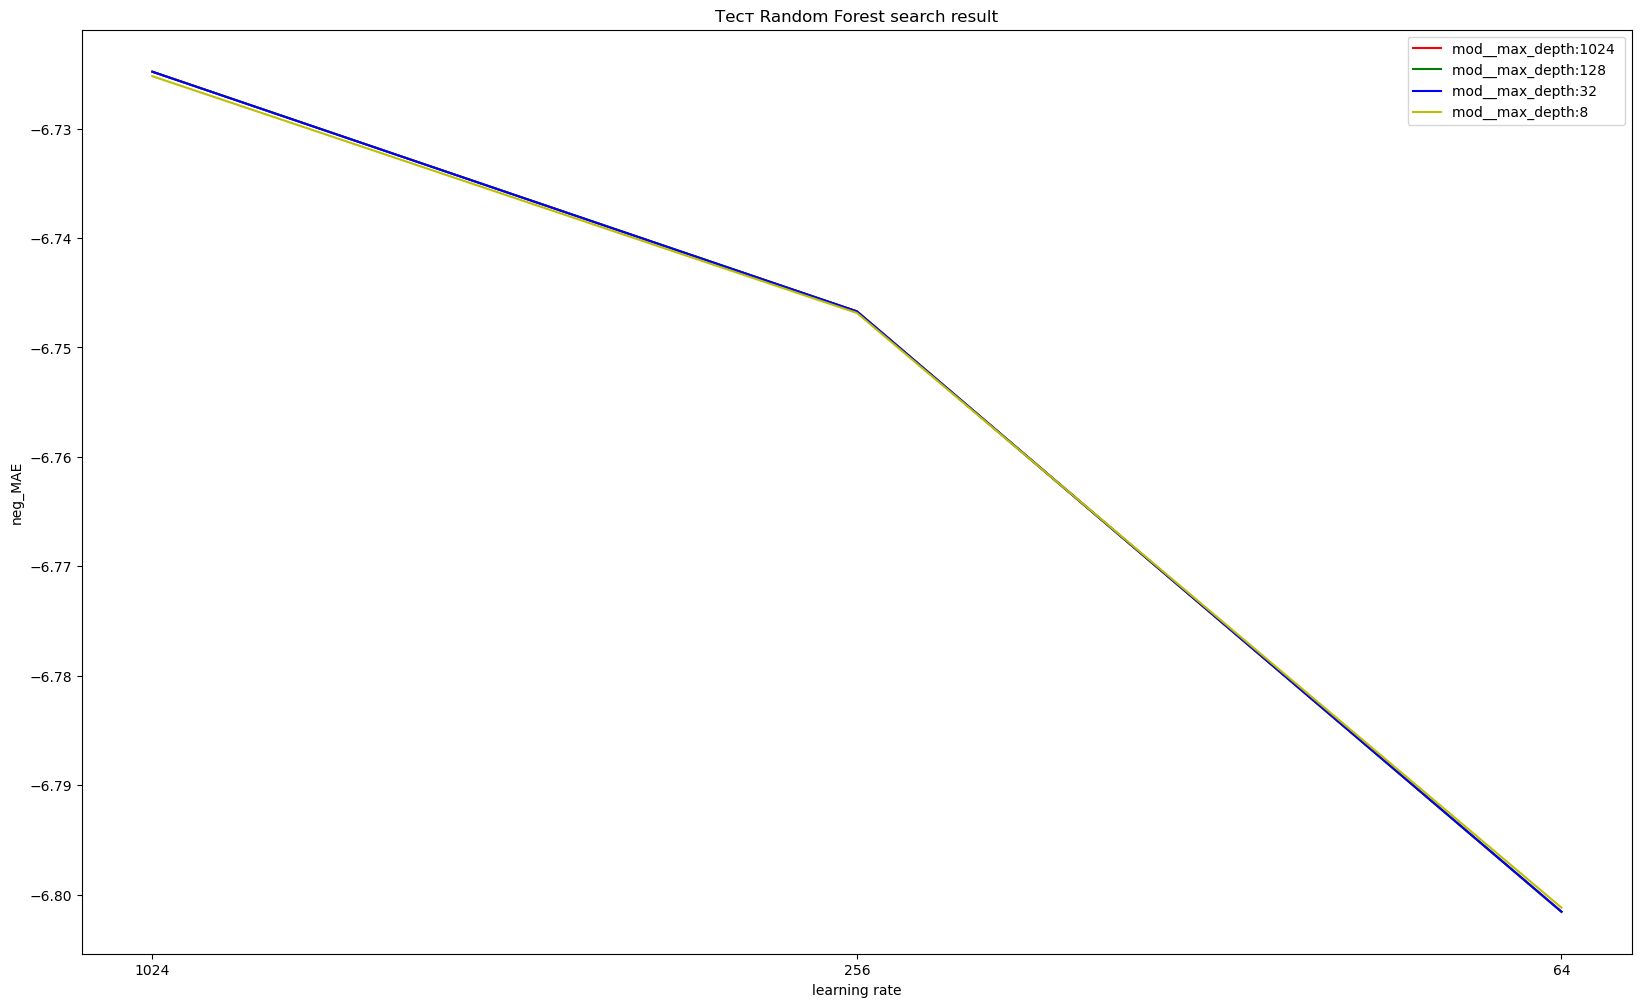

In [66]:
ResultPlotter(rf_sel,{'title':'Random Forest search result','metric':'neg_MAE'}).plot()

Модель RandomForest от LGBM показала заметно худшие результаты , но еще подходящие под условия проекта (MAE 6.72 при требуемых 6.8).   
Результат абслютно не зависит от глубины дерева, но заметно зависит от количества деревьев.
Как и в линейной модели, предварительные трансформеры не сильно влияют на результат, но эффективность обратная - лучше всего показал себя аггрегатор плавок, хуже всего - тривиальный трансформер.  
Предполагаю, что большое число признаков создает проблемы для этой модели

### MLP Regressor

Протестирована простая нейронная сеть , в основном я экспеременитровал со структурой уровней,   
предполагая, что их размеры должны соответствовать числу актальных параметров

In [67]:
%%time
power_tf = PowerTransformer()
scaler = StandardScaler()
model = MLPRegressor( max_iter =16_000,random_state=RANDOM_STATE)
scoring=['neg_mean_absolute_error','r2']
refit = scoring[0]
tier_levels = [len(tier1_cols+tier2_cols+tier3_cols),len(tier1_cols+tier2_cols),len(tier1_cols),len(tier1_cols)//2,8]

params_grid = {
    'mod__hidden_layer_sizes':[ [8] , [128,64,32,16],[128,64,64,32,32,16,16],tier_levels ],
    'mod__learning_rate_init':  [.8,.6,.4,.2,.1,.05],
    'mod__epsilon':[1e-8],#,1e-6,1e-4,1e-2],
    'mod__solver': ['adam']     
}

pipe = Pipeline( [['pow', power_tf],['sca',scaler],['mod',model]])
mlp_gcv = GridSearchCV(pipe,params_grid,cv =4,scoring=scoring,refit=refit)
mlp_gcv.fit(df_tr[X],df_tr[y])
mlp_gcv.best_score_,mlp_gcv.best_params_

CPU times: user 1min 53s, sys: 30 µs, total: 1min 53s
Wall time: 1min 53s


(-7.9649691102459474,
 {'mod__epsilon': 1e-08,
  'mod__hidden_layer_sizes': [128, 64, 32, 16],
  'mod__learning_rate_init': 0.6,
  'mod__solver': 'adam'})

In [68]:
mlp_gcv.cv_results_

{'mean_fit_time': array([0.10930586, 0.09933394, 0.14194053, 0.20754403, 0.28597254,
        0.45512843, 0.25329041, 1.91752869, 1.98812258, 3.27669883,
        0.43235564, 0.33283377, 0.16551924, 0.50697786, 0.30658007,
        4.06765521, 0.5645926 , 0.76428276, 3.14357167, 4.00825751,
        4.21210808, 0.18492079, 0.37784404, 0.47610658]),
 'std_fit_time': array([0.01519439, 0.02010869, 0.05402736, 0.04070474, 0.09861135,
        0.02909633, 0.01410567, 2.87227555, 3.05596601, 4.64791791,
        0.14606196, 0.09418573, 0.09624905, 0.51626025, 0.07915808,
        6.36727582, 0.10881575, 0.10706534, 3.02467914, 2.21743807,
        2.30918108, 0.08525897, 0.08005115, 0.12729561]),
 'mean_score_time': array([0.00244009, 0.00209546, 0.0021981 , 0.00215966, 0.00254279,
        0.00233734, 0.00255716, 0.00268167, 0.00263619, 0.00265282,
        0.00267559, 0.00268143, 0.0028879 , 0.00276196, 0.00279212,
        0.0027864 , 0.00282431, 0.00273973, 0.00242954, 0.00255108,
        0.002396

In [69]:
mlp_pars = ParsedResult(mlp_gcv.cv_results_,metric_name='neg_mean_absolute_error')
#idx = pd.IndexSlice
mlp_sel = mlp_pars.select('mod__learning_rate_init')#.loc[:,idx[:,:,'gbdt']] 
mlp_sel

mean_test_neg_mean_absolute_error  \
mod__hidden_layer_sizes                 [128, 64, 32, 16]   
mod__learning_rate_init                                     
0.05                                           -65.953194   
0.1                                            -71.204918   
0.2                                            -68.333113   
0.4                                           -397.461077   
0.6                                             -7.964969   
0.8                                             -7.974865   

                                                                           \
mod__hidden_layer_sizes [128, 64, 64, 32, 32, 16, 16] [78, 45, 26, 13, 8]   
mod__learning_rate_init                                                     
0.05                                       -63.713562          -58.895778   
0.1                                        -71.347150          -72.605970   
0.2                                       -421.453150         -424.876011   
0.4                                         -8.938258           -7.992280   
0.6                                        -66.175970          -15.540136   
0.8                                      -1205.254719         -422.271407   

                                    
mod__hidden_layer_sizes        [8]  
mod__learning_rate_init             
0.05                    -52.819735  
0.1                     -54.779830  
0.2                     -55.044051  
0.4                     -54.235239  
0.6                     -60.269104  
0.8                     -58.753710

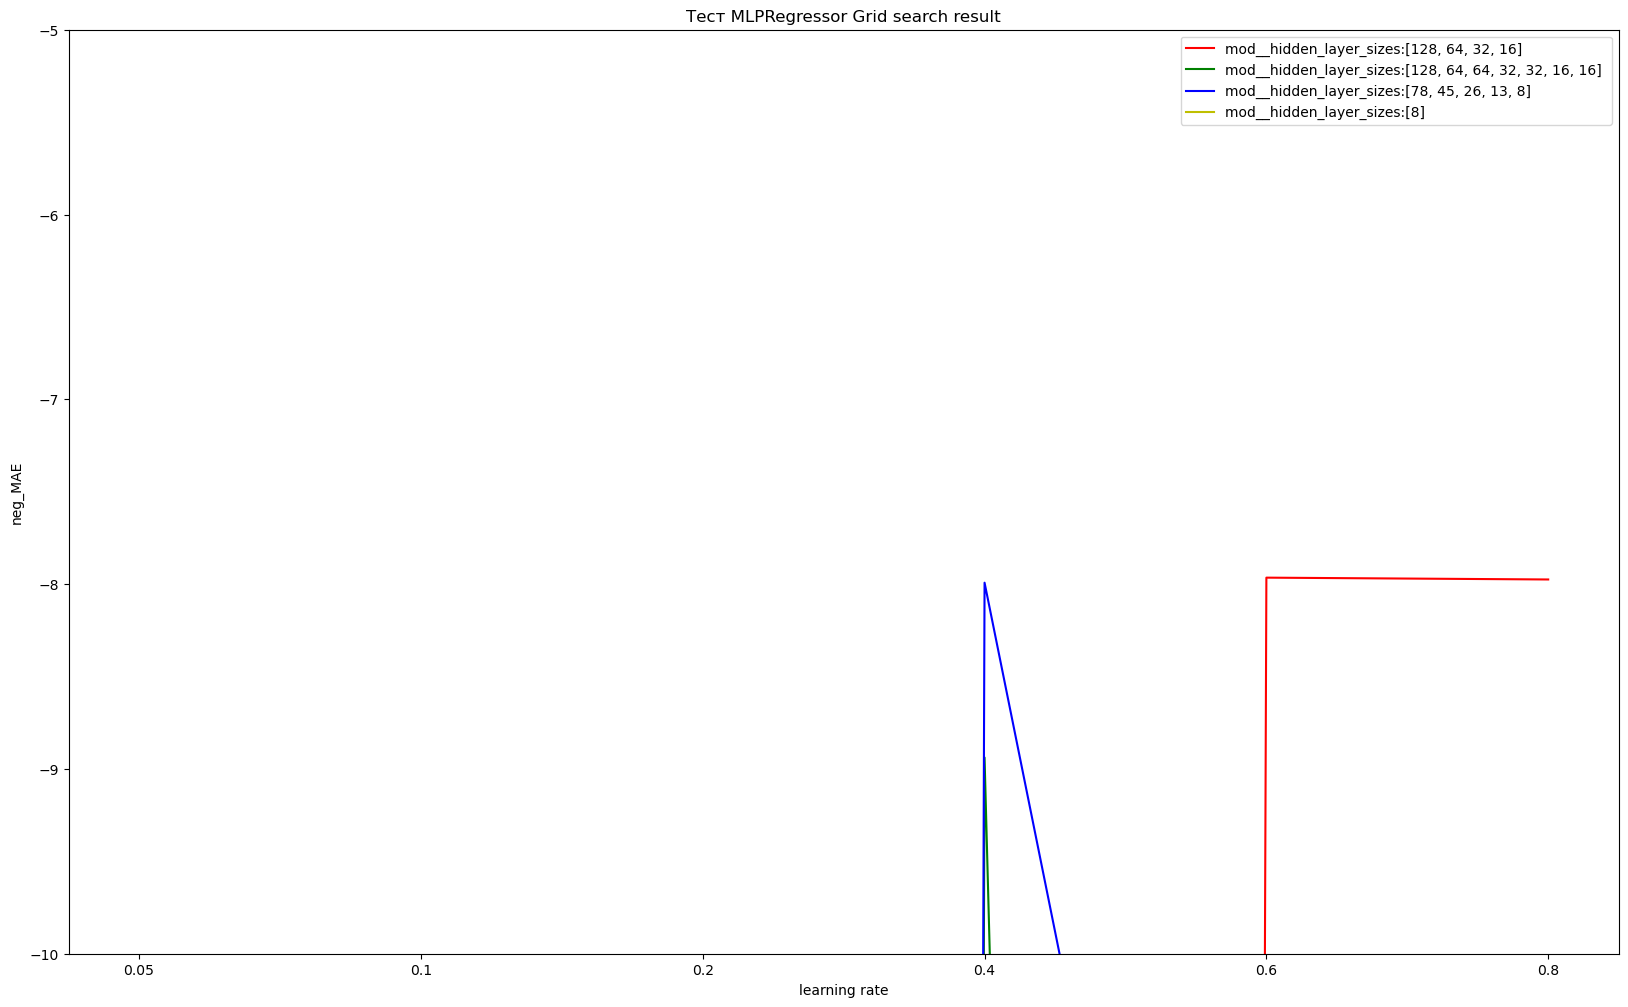

In [70]:
ResultPlotter(mlp_sel,{'title':'MLPRegressor Grid search result','metric':'neg_MAE'}).plot()
plt.ylim(-10,-5);
plt.show()

С нейронной сетью не удалось достигнуть требуемого результата, лучшая метрика MAE = 7.97 и это даже хуже baseline= 7.93  
Анализ параметров не имеет особого смысла, в большинстве случаев обучение срывалось.     
Можно тольок констатировать для большинства стратегий максимум метрики при скоростях обучения 0.4 и выше

### Финальный тест

Для финального теста выбрана модель SGDRegressor с параметрами подобранными при кроссвалидации 

In [71]:
y_pr = lin_gcv.best_estimator_.predict(df_te[X])
print_metrics(df_te[y],y_pr)

mean_absolute_error: 5.575299472535711 
RMSE: 7.654004029553163 
r2_score: 0.572572901905007 


{'mean_absolute_error': 5.575299472535711,
 'RMSE': 7.654004029553163,
 'r2_score': 0.572572901905007}

В финальном тесте получена метрика MAE = <b>5.58</b>

### Анализ влияния признаков на результат 

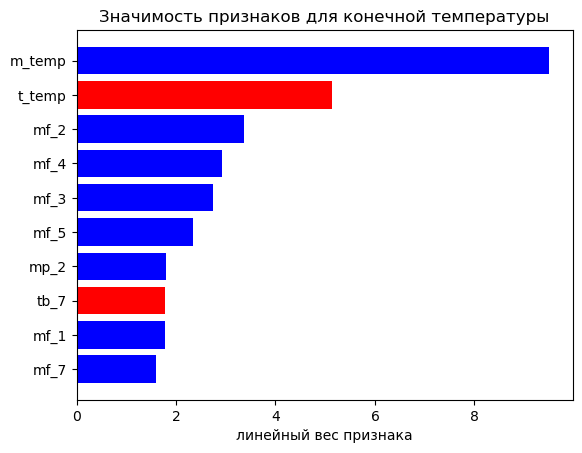

In [72]:
fe_names = df[X].columns 
pipe = lin_gcv.best_estimator_
pipe.fit(df[X], df[y])

model = pipe['mod']
fe_weights = model.coef_
fe_importance = np.argsort(-abs( model.coef_) )[:10][::-1]  
fe_colors = list( map(lambda x: ['r','b'][int(x>0)], fe_weights[fe_importance[:10]] ) )

plt.barh(fe_names[fe_importance],abs( fe_weights[fe_importance]),color=fe_colors) ;
plt.title("Значимость признаков для конечной температуры");
plt.xlabel("линейный вес признака");

Наибольшее значение имеет начальная температура,   
затем - момент измерения (с отрицательным весом )  
и полные мощности плавок.  
Из добавок больше всего влияют bulk 7 и wire 2 (обе снижают температуру)

## Выводы
* Моделирование позволяет предсказывать температуру с метрикой <b>MAE=5.6</b>
* Рекомендуется модель с низкими параметрами eta0 ~ 0.001
* Рекомендуется выгружать  в данных не время , полные моменты событий с датой
* ДЛя моделирования важны регулярные измерения температуры, поэтому надо выяснить причины несовпадения серий измерений с производственными операциями